In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams['figure.dpi'] = 150
import seaborn as sns
import scipy.stats as st
import statsmodels
import statsmodels.api as sm
from functools import reduce

import glob, os, yaml, subprocess, itertools, sparse, sys, statsmodels
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

eigenvec_df = pd.read_csv("../PCA/eigenvec_100PC.csv", index_col=[0])
who_variants_combined = pd.read_csv("who_confidence_2021.csv")
analysis_dir = '/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue'

lineages = pd.read_csv("../data/combined_lineages_samples.csv", low_memory=False).query("Sample_ID in @eigenvec_df.index")
print(lineages.shape)
import collections, warnings
warnings.filterwarnings("ignore")

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "utils"))
from stats_utils import *

coll2014 = pd.read_csv("../data/coll2014_SNP_scheme.tsv", sep="\t")
coll2014["#lineage"] = coll2014["#lineage"].str.replace("lineage", "")
coll2014.rename(columns={"#lineage": "Lineage"}, inplace=True)

drug_abbr_dict = {"Delamanid": "DLM",
                  "Bedaquiline": "BDQ",
                  "Clofazimine": "CFZ",
                  "Ethionamide": "ETH",
                  "Linezolid": "LZD",
                  "Moxifloxacin": "MXF",
                  "Capreomycin": "CAP",
                  "Amikacin": "AMI",
                  "Pretomanid": "PTM",
                  "Pyrazinamide": "PZA",
                  "Kanamycin": "KAN",
                  "Levofloxacin": "LEV",
                  "Streptomycin": "STM",
                  "Ethambutol": "EMB",
                  "Isoniazid": "INH",
                  "Rifampicin": "RIF"
                 }

# solo_initial_results = pd.read_excel("../results/SOLO primary_STATA_ver18Feb2023.xlsx", sheet_name=None)

# # remove the first row for now -- it denotes variables for ALL and WHO results, but cumbersome to handle in pandas
# solo_final_results = pd.read_csv("../results/SOLO_Final_Aug2023.csv", header=[1])

# if len(solo_initial_results) == 1:
#     solo_initial_results = solo_initial_results[list(solo_initial_results.keys())[0]]
solo_results = pd.read_csv("../results/SOLO_Final_Aug2023.csv", header=[1])

solo_binary_stats = pd.read_excel("~/who-analysis/results/sens_spec_19Jul2023.xlsx", sheet_name=None)

if len(solo_binary_stats) == 1:
    solo_binary_stats = solo_binary_stats["Sheet1"]

# get only the relevant group for comparison to regression
solo_binary_stats = solo_binary_stats.loc[(~pd.isnull(solo_binary_stats["TAB"])) & (solo_binary_stats["TAB"].str.contains('3'))][["drug", "Sens", "Spec", "PPV", "NPV", "propR", "PPV_lb", 'PPV_ub', 'NPV_lb', 'NPV_ub', 'Sens_lb', 'Sens_ub', 'Spec_lb',
       'Spec_ub', 'propR_lb', 'propR_ub', 'TP', 'TN', 'FP', 'FN']].rename(columns={"propR": "PropR", "propR_lb": "PropR_lb", "propR_ub": "PropR_ub"})

solo_binary_stats["Model"] = "SOLO"
solo_binary_stats = solo_binary_stats.set_index("Model")

solo_binary_stats[["Sens", "Spec", "PPV", "NPV", "PPV_lb", 'PPV_ub', 'NPV_lb', 'NPV_ub', 'Sens_lb', 'Sens_ub', 'Spec_lb',
       'Spec_ub', "PropR", "PropR_lb", "PropR_ub"]] /= 100

print(solo_binary_stats.shape)

drugs_lst = os.listdir(analysis_dir)

(49113, 7)
(15, 20)


In [4]:
single_lineages = lineages.query("~Coll2014.str.contains(',')")

# percent mixed lineage samples
print((len(lineages)-len(single_lineages)) / len(lineages))

# add primary lineage column
for i, row in single_lineages.iterrows():
    if row["Coll2014"][0].isnumeric():
        single_lineages.loc[i, "Lineage"] = row["Coll2014"][0]
    else:
        single_lineages.loc[i, "Lineage"] = row["Coll2014"]

0.010669272901268503


# 0. Correlations Between Lineages and Each PC

In [ ]:
LinToColor_Dict = {"1": "#f381b2",
                   "2": "#006dbb",
                   "3": "#9f5eab",
                   "4": "#f6472b",
                   "5": "#76400e",
                   "6": "#36ba74",
                   "7": "#ffb000",
                   "BOV": "gray",
                   "BOV_AFRI": "black"
                  }

def plot_PCA_colored_by_lineage(lineage_df, eigenvec_df, pc_x, pc_y, include_lineages=None, color_col="Lineage", color_dict=None, saveName=None):

    if include_lineages is None:
        include_lineages = lineage_df.Lineage.unique()
        color_col = "Lineage"
        color_dict = LinToColor_Dict
    else:
        color_dict = None
        
    plot_df = lineage_df.query("Lineage in @include_lineages").merge(eigenvec_df, left_on="Sample_ID", right_index=True, how="inner")
        
    fig, ax = plt.subplots(figsize=(5, 4))
    
    if color_dict is None:
        sns.scatterplot(data=plot_df,
                        x=pc_x,
                        y=pc_y,
                        hue=color_col,
                        alpha=0.7,
                        s=20,
                        ax=ax
                        )
    else:
        sns.scatterplot(data=plot_df,
                        x=pc_x,
                        y=pc_y,
                        hue=color_col,
                        hue_order=np.sort(include_lineages),
                        palette=color_dict,
                        alpha=0.7,
                        s=20,
                        ax=ax
                        )
    
    sns.move_legend(ax, fontsize=8, title='', loc='best', bbox_to_anchor=(1, 1))

    # for lh in ax._legend.legendHandles: 
    #     lh._sizes = [10] 
    #     # You can also use lh.set_sizes([50])

    ax.tick_params(axis='both', which='major', labelsize=8)
    sns.despine()

    if saveName is None:
        plt.show()
    else:
        if not os.path.isdir(os.path.dirname(saveName)):
            os.makedirs(os.path.dirname(saveName))
        plt.savefig(saveName, dpi=300, bbox_inches="tight")

In [ ]:
scaler = StandardScaler()

combined_single_lineage_PC = pd.get_dummies(single_lineages.set_index("Sample_ID")["Lineage"]).astype(int).merge(eigenvec_df, left_index=True, right_index=True)

def get_lineage_correlations_with_PC(lineage, sig_thresh=0.01):

    single_lineage_pvals = pd.DataFrame(columns=["rho", "pval", "PC", "abs_rho"])
    
    for i, col in enumerate(combined_single_lineage_PC.columns[combined_single_lineage_PC.columns.str.contains("PC")]):
    
        # rho, pval = st.pointbiserialr(combined_single_lineage_PC[lineage].values, combined_single_lineage_PC[col].values)
        rho, pval = st.spearmanr(scaler.fit_transform(combined_single_lineage_PC[lineage].values.reshape(-1, 1)), combined_single_lineage_PC[col].values)
        single_lineage_pvals.loc[i, :] = [rho, pval, int(col.replace("PC", "")), np.abs(rho)]
    
    single_lineage_pvals["Bonferroni_pval"] = np.min([single_lineage_pvals["pval"] * len(single_lineage_pvals), np.ones(len(single_lineage_pvals))], axis=0)
    return single_lineage_pvals.query("Bonferroni_pval < @sig_thresh")

In [18]:
lineage_corr_dict = {}

for lineage in np.sort(single_lineages.Lineage.unique()):

    num_lineage = len(single_lineages.query("Lineage==@lineage"))
    
    if num_lineage / len(single_lineages) >= 0.005:
        lineage_corr_dict[lineage] = get_lineage_correlations_with_PC(lineage)
        print(lineage, num_lineage, lineage_corr_dict[lineage].query("abs_rho >= 0.1").PC.max())

1 4062 68
2 15829 36
3 5619 41
4 22732 32
BOV_AFRI 279 27


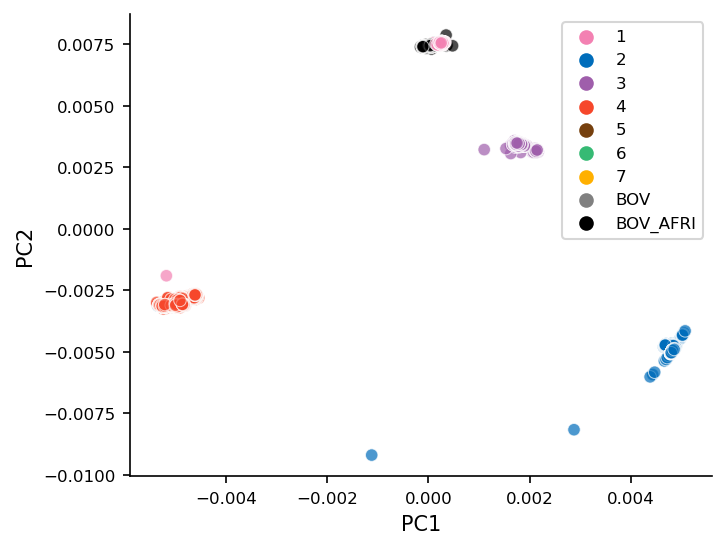

In [10]:
plot_PCA_colored_by_lineage(single_lineages, 
                            eigenvec_df, 
                            pc_x='PC1', pc_y='PC2', 
                            include_lineages=None,
                            color_col="Lineage", 
                            color_dict=LinToColor_Dict, 
                            #saveName='PC1_PC2_single_lineages.png'
                           )

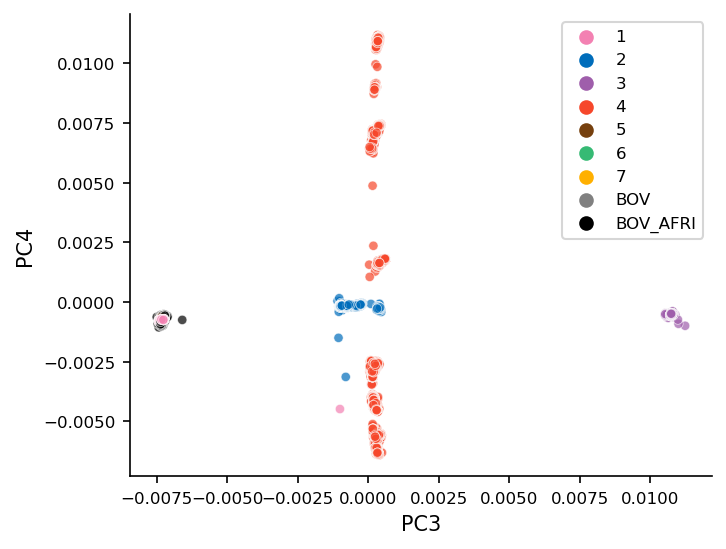

In [34]:
plot_PCA_colored_by_lineage(single_lineages, 
                            eigenvec_df, 
                            pc_x='PC3', pc_y='PC4', 
                            include_lineages=None,
                            color_col="Lineage", 
                            color_dict=LinToColor_Dict, 
                            #saveName='PC1_PC2_single_lineages.png'
                           )

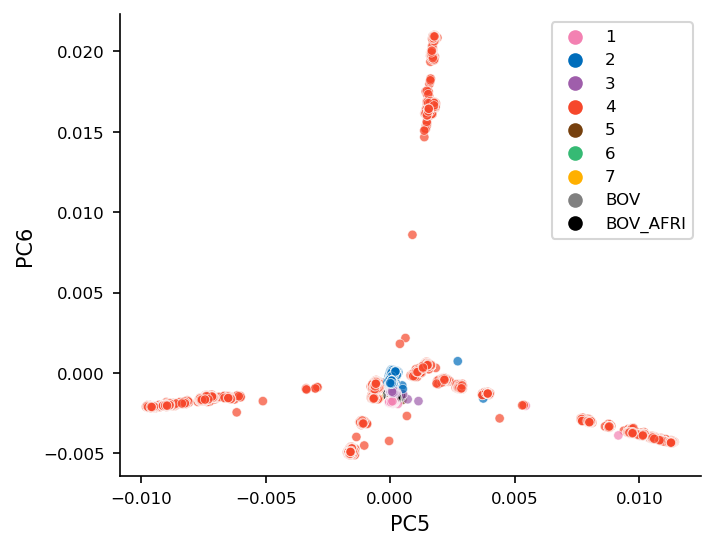

In [35]:
plot_PCA_colored_by_lineage(single_lineages, 
                            eigenvec_df, 
                            pc_x='PC5', pc_y='PC6', 
                            include_lineages=None,
                            color_col="Lineage", 
                            color_dict=LinToColor_Dict, 
                            #saveName='PC1_PC2_single_lineages.png'
                           )

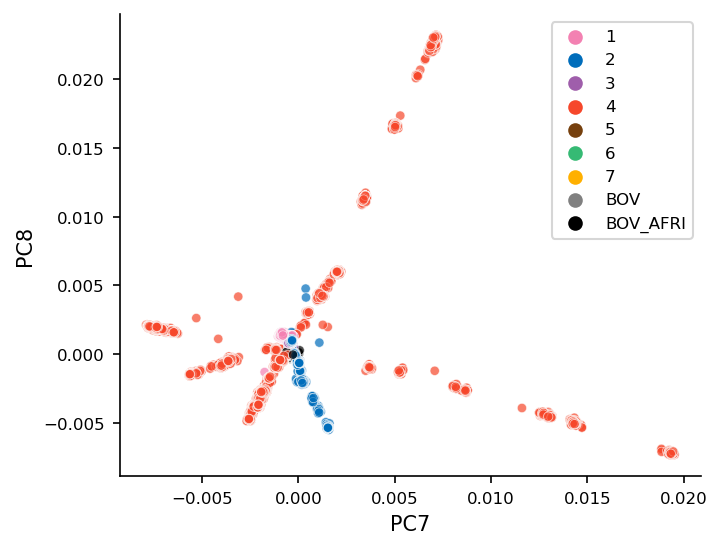

In [36]:
plot_PCA_colored_by_lineage(single_lineages, 
                            eigenvec_df, 
                            pc_x='PC7', pc_y='PC8', 
                            include_lineages=None,
                            color_col="Lineage", 
                            color_dict=LinToColor_Dict, 
                            #saveName='PC1_PC2_single_lineages.png'
                           )

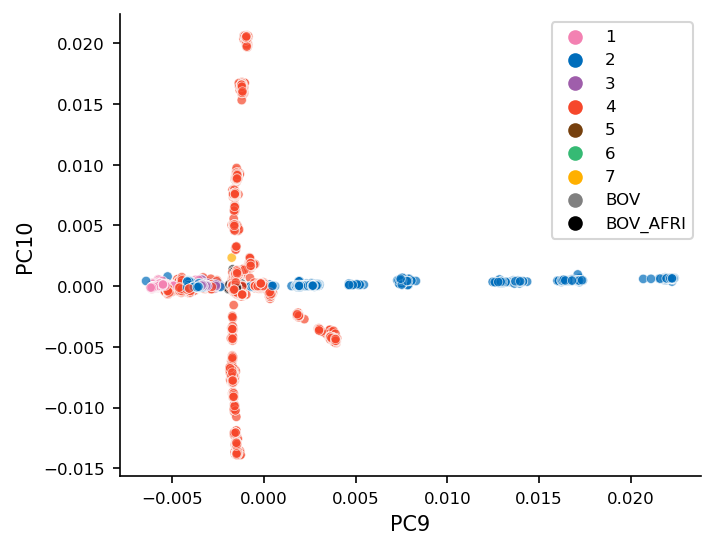

In [37]:
plot_PCA_colored_by_lineage(single_lineages, 
                            eigenvec_df, 
                            pc_x='PC9', pc_y='PC10', 
                            include_lineages=None,
                            color_col="Lineage", 
                            color_dict=LinToColor_Dict, 
                            #saveName='PC1_PC2_single_lineages.png'
                           )

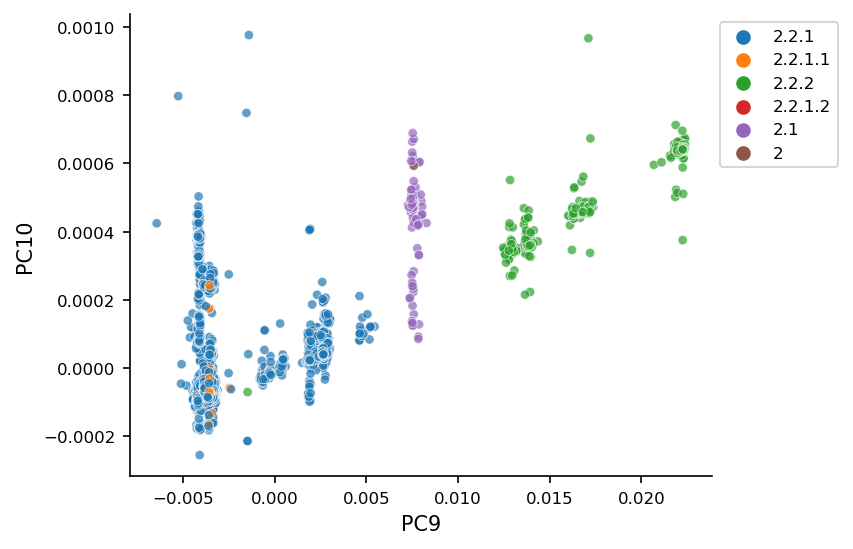

In [38]:
plot_PCA_colored_by_lineage(single_lineages, 
                            eigenvec_df, 
                            pc_x='PC9', pc_y='PC10', 
                            include_lineages=["2"],
                            color_col="Coll2014", 
                            color_dict=LinToColor_Dict, 
                            #saveName='PC1_PC2_single_lineages.png'
                           )

In [92]:
lineage_corr_dict["1"].query("abs_rho >= 0.1 & PC > 10").sort_values("abs_rho", ascending=False)

,rho,pval,PC,abs_rho,Bonferroni_pval
11,-0.255481,0.0,12,0.255481,0.0
12,-0.242812,0.0,13,0.242812,0.0
14,-0.240683,0.0,15,0.240683,0.0
27,-0.216566,0.0,28,0.216566,0.0
13,-0.215431,0.0,14,0.215431,0.0
26,-0.20933,0.0,27,0.20933,0.0
29,-0.194224,0.0,30,0.194224,0.0
22,-0.182905,0.0,23,0.182905,0.0
20,-0.173841,0.0,21,0.173841,0.0
25,0.164599,0.0,26,0.164599,0.0


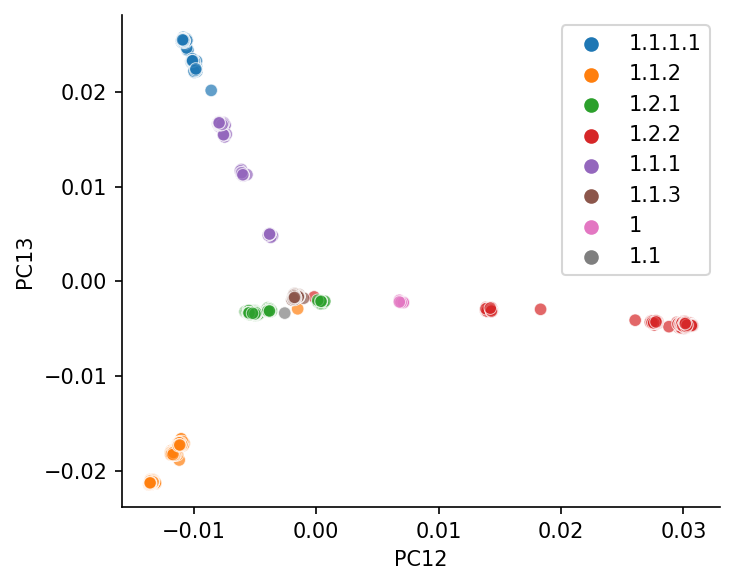

In [98]:
plot_PCA_colored_by_lineage(single_lineages, 
                            eigenvec_df, 
                            pc_x='PC12', pc_y='PC13', 
                            include_lineages=["1"],
                            color_col="Coll2014", 
                            color_dict=None, 
                            #saveFig='PC1_PC2_single_lineages.png'
                           )

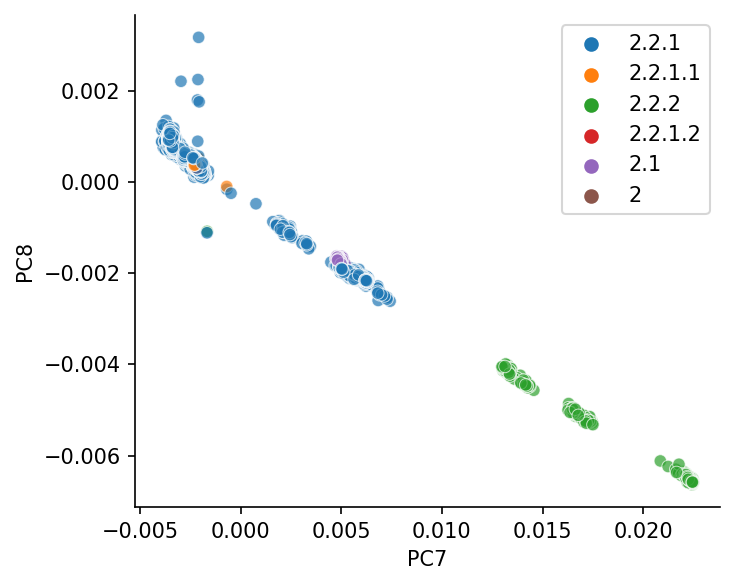

In [61]:
plot_PCA_colored_by_lineage(single_lineages, ['2'], eigenvec_df,
                            color_col="Coll2014", #color_dict=LinToColor_Dict, 
                            pc_x='PC7', pc_y='PC8', 
                            #saveFig='PC1_PC2_single_lineages.png'
                           )

# 0. Levofloxacin Lineage PC Investigation

## A. Plot coefficients with 5 PCs vs. 10/20/50/100
## B. Compare classifications -- make the 5 x 5 table like for comparing regression and SOLO

In [3]:
model_path = os.path.join(analysis_dir, "Levofloxacin", "BINARY", "tiers=1/phenos=WHO/dropAF_withSyn_unpooled")

# model_analysis_5PC = pd.read_csv(os.path.join(model_path, "model_analysis.csv"))
# model_analysis_100PC = pd.read_csv(os.path.join(model_path, "model_analysis_100PC.csv"))
# LRT_100PC = pd.read_csv(os.path.join(model_path, "LRT_results_100PC.csv"))
# LRT_100PC = add_pval_corrections(LRT_100PC.iloc[1:, ])

In [4]:
def combine_permutation_and_LRT(model_path, num_PCs):
    
    if num_PCs == 5:
        suffix = ""
    else:
        suffix = f"_{num_PCs}PC"
        
    model_analysis = pd.read_csv(os.path.join(model_path, f"model_analysis{suffix}.csv"))
    LRT_results = pd.read_csv(os.path.join(model_path, f"LRT_results{suffix}.csv"))
    
    if "mutation" not in LRT_results.columns:
        LRT_results.rename(columns={LRT_results.columns[0]: "mutation"}, inplace=True)
    
    LRT_results = add_pval_corrections(LRT_results.iloc[1:, ])
    
    return model_analysis.merge(LRT_results[["mutation", "BH_pval", "neutral_BH_pval"]].rename(columns={"BH_pval": "LRT_BH_pval"}), on="mutation")
#     final["PC"] = num_PCs
    
#     return final

In [5]:
def add_significance_category(df, tiers_lst, phenos_name, num_PCs):
    '''
    Add significance category annotations, in the form of integers. Add the ones with the fewest requirements first, and then progressively add
    '''
        
    if num_PCs != 5:
        col_name = f"regression_confidence_{num_PCs}PC"
    else:
        col_name = "regression_confidence"
    
    # lower significance threshold for tier 2 genes and if fit on ALL phenotypes
    if len(tiers_lst) == 2 or phenos_name == "ALL":
        thresh = 0.01
    else:
        thresh = 0.05
    
    # uncertain = significant coefficient, but it could be positive or negative
    df.loc[(df["BH_pval"] < thresh) & (df["Odds_Ratio"] > 1), col_name] = "Possible Assoc w R"
    df.loc[(df["BH_pval"] < thresh) & (df["Odds_Ratio"] < 1), col_name] = "Possible Assoc w S"
    
    # df.loc[(df[col_name] == "Possible Assoc w R") & 
    #        (df["LRT_BH_pval"] < thresh) & (df["PPV_LB"] >= 0.25), col_name] = "Assoc w R - rare"
    
    df.loc[(df[col_name] == "Possible Assoc w R") & 
           (df["LRT_BH_pval"] < thresh) & (df["Num_Isolates"] >= 5) & (df["PPV_LB"] >= 0.25), col_name] = "Assoc w R - strict"
    
    # df.loc[(df[col_name] == "Possible Assoc w S") & 
    #        (df["LRT_BH_pval"] < thresh) & (df["NPV_LB"] >= 0.25), col_name] = "Assoc w S - rare"
    
    df.loc[(df[col_name] == "Possible Assoc w S") & 
           (df["LRT_BH_pval"] < thresh) & (df["Num_Isolates"] >= 5) & (df["NPV_LB"] >= 0.25), col_name] = "Assoc w S - strict"

    # neutral mutations: not significant in regression AND significant in the neutral LRT test AND present at high enough frequency
    # should be in the lowest tail of the p-value.
    # so a mutation is significant in regression if p-value < 0.05, then a mutation is significant in the neutral test if p-value > 0.95
    # This means that more than 95% of permuted samples are NOT AS EXTREME as the test statistic, indicating the probably the test statistic is not significant
    df.loc[(df["BH_pval"] > (1-thresh)) & (df["neutral_BH_pval"] < thresh) & (df["Num_Isolates"] >= 5), col_name] = "Neutral"
    
    # ALSO REPLACE THE UPPER OR LOWER BOUND OF THE ODDS RATIO WITH 1, DEPENDING ON THE DIRECTION
    df = df.reset_index(drop=True)

    df[col_name] = df[col_name].fillna("Uncertain")
    
    if num_PCs != 5:
        return df.rename(columns={"coef": f"coef_{num_PCs}PC"})
    else:
        return df

# Comparing Levofloxacin Results with 5,10,20,50,100 PCs

In [6]:
# drug = "Levofloxacin"
# folder = "BINARY"

# phenos_file = os.path.join(analysis_dir, drug, f"phenos_{folder.lower()}.csv")    
# df_phenos = pd.read_csv(phenos_file)
# annotated_genos = get_annotated_genos(analysis_dir, drug)

In [7]:
model_path = "/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Levofloxacin/BINARY/tiers=1/phenos=WHO/dropAF_withSyn_unpooled"
model_analyses_diffPC = {}

for num in [5, 10, 20, 50, 100]:
    # compute_statistics_single_model(model_path, f"_{num}PC", df_phenos, annotated_genos, alpha=0.05)
    model_analyses_diffPC[num] = add_significance_category(combine_permutation_and_LRT(model_path, num), ["1"], "WHO", num)

In [8]:
compare_classifications_df = model_analyses_diffPC[5][["mutation", "regression_confidence"]].merge(
    solo_results.query("drug=='Levofloxacin'")[["variant", "Initial_Confidence_Grading"]].rename(columns={"variant":"mutation"}), on="mutation")

for num in [10, 20, 50, 100]:
    compare_classifications_df = compare_classifications_df.merge(model_analyses_diffPC[num][["mutation", f"regression_confidence_{num}PC"]], on="mutation")

In [9]:
def compare_classfications_two_groups(df, group1, group2):
    
    df_copy = df.copy()
    group_names = ["Assoc w R - strict", "Possible Assoc w R", "Uncertain", "Possible Assoc w S", "Assoc w S - strict", "Neutral"]
    
    # if comparing to the SOLO output, convert the names to allow for the comparison
    if "Initial" in group1:
        switch_group = group2
    elif "Initial" in group2:
        switch_group = group1
    else:
        switch_group = None
        
    if switch_group is not None:
        df_copy[switch_group] = df_copy[switch_group].map(dict(zip(group_names, ['1) Assoc w R', '2) Assoc w R - interim', '3) Uncertain significance', 
                                                           '4) Not assoc w R - interim', '5) Not assoc w R', '5) Not assoc w R'])))
        group_names = ['1) Assoc w R', '2) Assoc w R - interim', '3) Uncertain significance', '4) Not assoc w R - interim', '5) Not assoc w R']

    # group_names = ["Assoc w R - strict", "Assoc w R - rare", "Possible Assoc w R", "Uncertain", "Possible Assoc w S", "Assoc w S - rare", "Neutral - rare", "Assoc w S - strict", "Neutral - strict"]
    

    # pairs = list(itertools.product(df[group1].unique(), df[group2].unique()))
    pairs = list(itertools.product(group_names, group_names))
    
    # get counts of mutations across the groups
    counts_df = pd.DataFrame(df_copy[[group1, group2]].value_counts()).reset_index().rename(columns={0:"Count"})

    # for pairs that are 0, they won't appear in the above dataframe, so manually add them with Count = 0
    for (a, b) in pairs:

        if len(counts_df.query(f"{group1}==@a & {group2}==@b")) == 0:
            counts_df = pd.concat([counts_df, pd.DataFrame({group1: a, 
                                                            group2: b,
                                                            "Count": 0
                                                           }, index=[0])])

    counts_df = counts_df.reset_index(drop=True)
    assert len(counts_df) == len(pairs)
    
    counts_df = counts_df.pivot(index=group1, columns=group2, values="Count").fillna(0).astype(int)
    return counts_df.loc[group_names, group_names]

In [ ]:
compare_groups_for_excel = {}

for num in [10, 20, 50, 100]:
    
    compare_groups_for_excel[f"{num}PC"] = compare_classfications_two_groups(compare_classifications_df, "regression_confidence", f"regression_confidence_{num}PC")
    
# with pd.ExcelWriter(f"../LEV_PC_analysis.xlsx") as file:
#     for name, df in compare_groups_for_excel.items():
#         df.to_excel(file, sheet_name=name)

In [ ]:
compare_groups_for_excel["10PC"]

regression_confidence_10PC,Assoc w R - strict,Possible Assoc w R,Uncertain,Possible Assoc w S,Assoc w S - strict,Neutral
regression_confidence,,,,,,
Assoc w R - strict,19,0,0,0,0,0
Possible Assoc w R,0,22,3,0,0,0
Uncertain,0,0,666,0,0,0
Possible Assoc w S,0,0,1,6,0,0
Assoc w S - strict,0,0,0,0,2,0
Neutral,0,0,0,0,0,0


In [ ]:
compare_classifications_df.query("regression_confidence!='Uncertain' & regression_confidence_10PC=='Uncertain'")

,mutation,regression_confidence,Initial_Confidence_Grading,regression_confidence_10PC,regression_confidence_20PC,regression_confidence_50PC,regression_confidence_100PC
16,gyrA_p.Gly668Asp,Possible Assoc w R,5) Not assoc w R,Uncertain,Uncertain,Uncertain,Uncertain
27,gyrB_p.Gly512Arg,Possible Assoc w R,3) Uncertain significance,Uncertain,Uncertain,Uncertain,Uncertain
29,gyrB_p.Val427Met,Possible Assoc w R,3) Uncertain significance,Uncertain,Possible Assoc w R,Possible Assoc w R,Possible Assoc w R
715,gyrA_c.2256G>C,Possible Assoc w S,3) Uncertain significance,Uncertain,Possible Assoc w S,Uncertain,Uncertain


In [ ]:
compare_classfications_two_groups(compare_classifications_df, "regression_confidence", "regression_confidence_20PC")

# compare_classifications_df.query("regression_confidence != 'Uncertain' & regression_confidence_10PC == 'Uncertain'")

regression_confidence_20PC,Assoc w R - strict,Possible Assoc w R,Uncertain,Possible Assoc w S,Assoc w S - strict,Neutral
regression_confidence,,,,,,
Assoc w R - strict,19,0,0,0,0,0
Possible Assoc w R,0,22,3,0,0,0
Uncertain,0,0,665,1,0,0
Possible Assoc w S,0,0,1,6,0,0
Assoc w S - strict,0,0,0,0,2,0
Neutral,0,0,0,0,0,0


In [ ]:
compare_classfications_two_groups(compare_classifications_df, "regression_confidence", "regression_confidence_50PC")

# compare_classifications_df.query("regression_confidence != 'Uncertain' & regression_confidence_10PC == 'Uncertain'")

regression_confidence_50PC,Assoc w R - strict,Possible Assoc w R,Uncertain,Possible Assoc w S,Assoc w S - strict,Neutral
regression_confidence,,,,,,
Assoc w R - strict,18,1,0,0,0,0
Possible Assoc w R,0,21,4,0,0,0
Uncertain,0,0,666,0,0,0
Possible Assoc w S,0,0,2,5,0,0
Assoc w S - strict,0,0,0,0,2,0
Neutral,0,0,0,0,0,0


In [ ]:
compare_classfications_two_groups(compare_classifications_df, "regression_confidence", "regression_confidence_100PC")

# compare_classifications_df.query("regression_confidence != 'Uncertain' & regression_confidence_10PC == 'Uncertain'")

regression_confidence_100PC,Assoc w R - strict,Possible Assoc w R,Uncertain,Possible Assoc w S,Assoc w S - strict,Neutral
regression_confidence,,,,,,
Assoc w R - strict,17,1,1,0,0,0
Possible Assoc w R,0,18,7,0,0,0
Uncertain,0,0,665,1,0,0
Possible Assoc w S,0,0,2,5,0,0
Assoc w S - strict,0,0,0,1,1,0
Neutral,0,0,0,0,0,0


In [ ]:
compare_classfications_two_groups(compare_classifications_df, "regression_confidence", "Initial_Confidence_Grading")

# compare_classifications_df.query("regression_confidence != 'Uncertain' & regression_confidence_10PC == 'Uncertain'")

Initial_Confidence_Grading,1) Assoc w R,2) Assoc w R - interim,3) Uncertain significance,4) Not assoc w R - interim,5) Not assoc w R
regression_confidence,,,,,
1) Assoc w R,13,0,6,0,0
2) Assoc w R - interim,0,0,24,0,1
3) Uncertain significance,0,0,648,2,16
4) Not assoc w R - interim,0,0,6,0,1
5) Not assoc w R,0,0,1,0,1


In [ ]:
compare_classifications_df.query("regression_confidence=='Uncertain' & Initial_Confidence_Grading=='5) Not assoc w R'")

,mutation,regression_confidence,Initial_Confidence_Grading,regression_confidence_10PC,regression_confidence_20PC,regression_confidence_50PC,regression_confidence_100PC
59,gyrA_c.1842T>C,Uncertain,5) Not assoc w R,Uncertain,Uncertain,Uncertain,Uncertain
85,gyrA_c.-34C>T,Uncertain,5) Not assoc w R,Uncertain,Uncertain,Uncertain,Uncertain
314,gyrA_p.Ala384Val,Uncertain,5) Not assoc w R,Uncertain,Uncertain,Uncertain,Uncertain
353,gyrA_p.Gly247Ser,Uncertain,5) Not assoc w R,Uncertain,Uncertain,Uncertain,Uncertain
513,gyrB_c.1578G>A,Uncertain,5) Not assoc w R,Uncertain,Uncertain,Uncertain,Uncertain
622,gyrA_p.Glu21Gln,Uncertain,5) Not assoc w R,Uncertain,Uncertain,Uncertain,Uncertain
635,gyrB_p.Met291Ile,Uncertain,5) Not assoc w R,Uncertain,Uncertain,Uncertain,Uncertain
667,gyrA_p.Ala463Ser,Uncertain,5) Not assoc w R,Uncertain,Uncertain,Uncertain,Uncertain
680,gyrB_p.Val301Leu,Uncertain,5) Not assoc w R,Uncertain,Uncertain,Uncertain,Uncertain
693,gyrB_c.1983C>T,Uncertain,5) Not assoc w R,Uncertain,Uncertain,Uncertain,Uncertain


# 0. Look at Lineage Distribution for Individual Mutations

## what percentage of each lineage have this variant, independent of any phenotype. Ideally in the BDQ data binary dataset that was used to estimate its effect that we report in the slides



In [39]:
BDQ_matrix = pd.read_pickle(os.path.join(analysis_dir, "Bedaquiline", "BINARY/tiers=1/phenos=WHO/dropAF_noSyn_unpooled/model_matrix.pkl"))
bdq_mic = pd.read_csv(os.path.join(analysis_dir, "Bedaquiline", "phenos_mic.csv"))
bdq_phenos = pd.read_csv(os.path.join(analysis_dir, "Bedaquiline", "phenos_binary.csv"))

In [55]:
var = "mmpL5_p.Thr794Ile"

# search_samples = set(BDQ_matrix.loc[BDQ_matrix[var]==1].index.values).intersection(bdq_mic.sample_id.values)
search_samples = BDQ_matrix.loc[BDQ_matrix[var]==1].index.values
print(len(search_samples))

final = pd.DataFrame(single_lineages.query("sample_id in @search_samples & ~Coll2014.str.contains(',')")["Lineage"].value_counts()).reset_index()
final = final.rename(columns={"index":"Lineage", "Lineage":f"{var}_Count"}).sort_values("Lineage")

1303


In [56]:
final

,Lineage,mmpL5_p.Thr794Ile_Count
2,1,109
0,2,875
1,3,307
3,BOV_AFRI,2


In [64]:
pd.DataFrame(single_lineages.merge(bdq_phenos.query("phenotypic_category=='WHO'"), on="sample_id")).Lineage.value_counts()

2           949
4           741
3           330
1           117
BOV_AFRI      2
Name: Lineage, dtype: int64

# 1. Numbers of R and S Isolates in each Model

In [3]:
def compute_number_of_isolates_per_model(drug, phenos_name, tiers_lst):
    
    fName = os.path.join(analysis_dir, drug, "BINARY", f"tiers={'+'.join(tiers_lst)}/phenos={phenos_name}", "dropAF_noSyn_unpooled/model_matrix.pkl")
    
    if os.path.isfile(fName):
        model_matrix = pd.read_pickle(fName)

        samples = model_matrix.index.values
        del model_matrix

        df_phenos = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_binary.csv")).query("sample_id in @samples")    
        return len(df_phenos.query("phenotype==1")), len(df_phenos.query("phenotype==0"))
    else:
        return 0, 0

In [4]:
RS_counts_tier1 = pd.DataFrame(columns=["Drug", "WHO_Num_R", "WHO_Num_S", "ALL_Num_R", "ALL_Num_S"])

for i, drug in enumerate(np.sort(os.listdir(analysis_dir))):
    
    num_R_WHO, num_S_WHO = compute_number_of_isolates_per_model(drug, "WHO", ["1"])
    num_R_ALL, num_S_ALL = compute_number_of_isolates_per_model(drug, "ALL", ["1"])
    
    RS_counts_tier1.loc[i, :] = [drug, num_R_WHO, num_S_WHO, num_R_ALL, num_S_ALL]

In [5]:
# RS_counts_tier1.to_csv("/home/sak0914/RS_counts_tier1.csv", index=False)
RS_counts_tier1

,Drug,WHO_Num_R,WHO_Num_S,ALL_Num_R,ALL_Num_S
0,Amikacin,1108,7619,2429,21602
1,Bedaquiline,763,1247,879,12984
2,Capreomycin,1299,8500,2024,15267
3,Clofazimine,213,4787,674,14181
4,Delamanid,51,514,246,11398
5,Ethambutol,6417,26112,9318,35284
6,Ethionamide,2161,3808,5129,15640
7,Isoniazid,13381,21433,20901,27725
8,Kanamycin,1589,6195,3492,20399
9,Levofloxacin,2568,9629,5562,21550


In [6]:
# counts are a little lower generally than tier 1 because there are more mutations across which there can be missingness, so more isolates were dropped
# RS_counts_tier12 = pd.DataFrame(columns=["Drug", "WHO_Num_R", "WHO_Num_S", "ALL_Num_R", "ALL_Num_S"])

# for i, drug in enumerate(np.sort(os.listdir(analysis_dir))):
    
#     num_R_WHO, num_S_WHO = compute_number_of_isolates_per_model(drug, "WHO", ["1", "2"])
#     num_R_ALL, num_S_ALL = compute_number_of_isolates_per_model(drug, "ALL", ["1", "2"])
    
#     RS_counts_tier12.loc[i, :] = [drug, num_R_WHO, num_S_WHO, num_R_ALL, num_S_ALL]

# 2. Lineage Counts per Drug Model

In [7]:
def create_lineage_summary_df(og_lineages_df, other_thresh=0.01):
    '''
    other_cols is a list of lineages that should be combined into an other category because there are so few of them. Basically just for aesthetic purposes
    '''
    
    lineage_summary = pd.DataFrame(og_lineages_df["Lineage"].value_counts())

    lineage_summary = lineage_summary.reset_index().rename(columns={"index":"Lineage", "Lineage": "Count"})
    
    # get lineages that are present at < 1% frequency. Combine them into an "Other" category for aesthetic purposes in plotting
    samples_total = lineage_summary["Count"].sum()
    samples_thresh = int(other_thresh*samples_total)
    other_cols = lineage_summary.query("Count < @samples_thresh")["Lineage"].values
    
    # ",".join(other_cols) --> this makes the name too long, but can try later
    # combine low-frequency lineages into an Other category
    lineage_summary = pd.concat([lineage_summary, 
                                 pd.DataFrame({"Lineage": "Other", "Count": lineage_summary.query("Lineage in @other_cols")["Count"].sum()
                                              }, index=[-1])
                                ]).query("Lineage not in @other_cols")
    
    lineage_summary = lineage_summary.sort_values("Lineage", ascending=True).reset_index(drop=True)
    lineage_summary["Count"] = lineage_summary["Count"].astype(int)
    return lineage_summary

In [12]:
create_lineage_summary_df(single_lineages)

,Lineage,Count
0,1,4062
1,2,15829
2,3,5621
3,4,22730
4,Other,354


In [10]:
def compute_number_of_lineages_per_model(drugs_lst, lineages_df):
    
    lineage_summaries_by_drug = []
    
    for drug in drugs_lst:
        
        # fName = os.path.join(analysis_dir, drug, "BINARY", f"tiers={'+'.join(tiers_lst)}/phenos={phenos_name}", "dropAF_noSyn_unpooled/model_matrix.pkl")
        fName = os.path.join(analysis_dir, drug, "phenos_binary.csv")

        if os.path.isfile(fName):
#             model_matrix = pd.read_pickle(fName)

#             samples = model_matrix.index.values
#             del model_matrix
            df_phenos = pd.read_csv(fName)
            samples = df_phenos["sample_id"].values
        
            single_drug_lineage_summary = create_lineage_summary_df(lineages_df.query("sample_id in @samples"), other_thresh=0.01)
            single_drug_lineage_summary["Drug"] = drug_abbr_dict[drug]

            lineage_summaries_by_drug.append(single_drug_lineage_summary)
        
    return pd.concat(lineage_summaries_by_drug, axis=0)

In [11]:
single_drug_lineage_summary = compute_number_of_lineages_per_model(os.listdir(analysis_dir), single_lineages)

In [17]:
single_drug_lineage_summary.pivot(index="Drug", columns="Lineage", values="Count")#.to_csv("ALL_isolates_by_lineage.csv")

Lineage,1,2,3,4,Other
Drug,,,,,
AMI,1286,9391,2216,11131,53
BDQ,833,5409,1376,6312,28
CAP,867,7177,1635,7104,25
CFZ,1097,5614,1964,5998,34
DLM,723,4335,1223,5350,29
EMB,3446,12867,4525,20791,321
ETH,1204,7812,1967,8694,47
INH,3669,14350,4985,21509,310
KAN,1334,9096,2275,10530,55


In [13]:
def create_stacked_percent_bar_chart(df, xvar, quantVar, hueVar, saveName=None):
    
    LinToColor_Dict = {"1": "#f381b2",
                       "2": "#006dbb",
                       "3": "#9f5eab",
                       "4": "#f6472b",
                       "5": "#76400e",
                       "Other": "white"
                      }
    
#     LinToColor_Dict = {"1": "#DF83AC",
#                    "2": "#7098CB",
#                    "3": "#815D9F",
#                    "4": "#E76956",
#                    "5": "#B67548",
#                    "6": "#6AB79E",
#                    "8": "#E4515B",
#                    "Other": "black"
#                       }
    
    # set the figure size
    fig, ax = plt.subplots(figsize=(12, 4))

    # # dataframe of total counts by lineage
    # total = df.groupby(xvar)[quantVar].sum().reset_index()

    lineage_stacked_for_plotting = df.pivot(index="Drug", columns="Lineage", values="Count")
    lineage_stacked_for_plotting["Total"] = lineage_stacked_for_plotting.sum(axis=1)
    lineage_stacked_for_plotting = lineage_stacked_for_plotting.fillna(0)

    # compute proportions for plotting
    for lineage in df["Lineage"].unique():
        lineage_stacked_for_plotting[lineage] = lineage_stacked_for_plotting[lineage] / lineage_stacked_for_plotting["Total"]
        
    del lineage_stacked_for_plotting["Total"]
    lineage_stacked_for_plotting = lineage_stacked_for_plotting.reset_index().melt(id_vars="Drug")
        
    # keep track of all the groups to increase the start value of the next bar
    prev_vals_array = np.zeros(len(lineage_stacked_for_plotting[xvar].unique()))
    
    # order in increasing lineage abundance for each drug
    lineage_stacked_for_plotting = lineage_stacked_for_plotting.sort_values(["Drug", "value"], ascending=[True, False])
    
    # iterate through the Lineages and convert to percentages
    color_groups = lineage_stacked_for_plotting[hueVar].unique()
    
    for i, color_group in enumerate(color_groups):        
                        
        # dataframe of proportion of each drug's samples that belong to the current lineage
        single_group = lineage_stacked_for_plotting[lineage_stacked_for_plotting[hueVar]==color_group].groupby(xvar)["value"].sum().reset_index()

        if i > 0:
            prev_vals = lineage_stacked_for_plotting[lineage_stacked_for_plotting[hueVar]==color_groups[i-1]].groupby(xvar)["value"].sum().reset_index()["value"].values 
            prev_vals_array += prev_vals
            
        ax.bar(single_group[xvar].values, 
               single_group["value"].values, 
               color=LinToColor_Dict[color_group], 
               bottom = prev_vals_array, 
               edgecolor="black",
               label=color_group,
              )
    
        # the other group is very tiny and not worth plotting
        if color_group != "Other":
            label_loc = 'center'
            annot_format = '{:.2f}'
            ax.bar_label(ax.containers[i], fmt=annot_format, label_type=label_loc, fontsize='9')
    
    plt.setp(ax.patches, linewidth=0.75)
    sns.despine()
    
    bar_scale = 0.85
    for patch in ax.patches:
        current_width = patch.get_width()
        patch.set_width(current_width * bar_scale)
    
    # Rearrange the handles and labels
    handles, labels = ax.get_legend_handles_labels()    
    handles_labels_dict = dict(zip(labels, handles))
    handles_labels_dict = collections.OrderedDict(sorted(handles_labels_dict.items()))

    # Create the legend with the rearranged handles and labels
    ax.legend(list(handles_labels_dict.values()), list(handles_labels_dict.keys()))
    sns.move_legend(ax, fontsize=8, title='Lineage', loc='upper right', #bbox_to_anchor=(1.05, 0.65),
                    ncol=len(color_groups),
                   bbox_to_anchor=(0.65, -0.1))

    if saveName is not None:
        plt.savefig(saveName, dpi=300, bbox_inches='tight')
    else:
        plt.show()

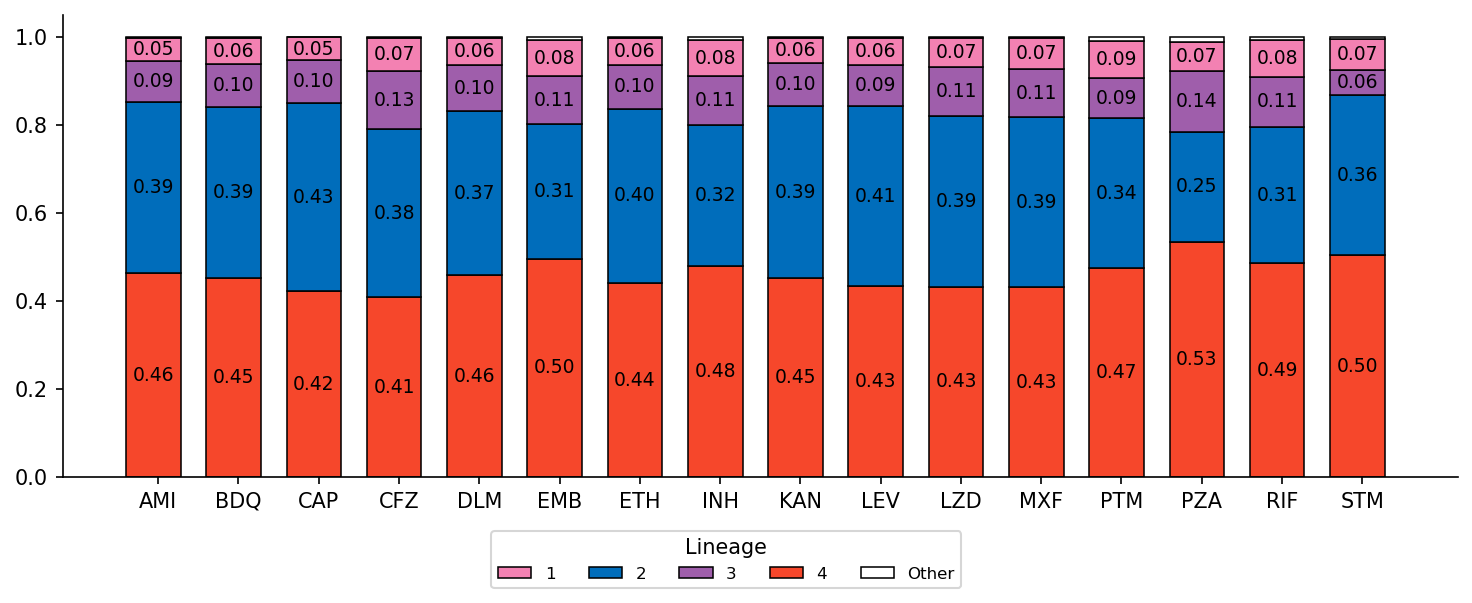

In [14]:
create_stacked_percent_bar_chart(single_drug_lineage_summary, "Drug", "Count", "Lineage", saveName="samples_by_lineage_stacked_bar.png")

In [174]:
def compute_mean_resistance_by_primary_lineage(drug, lineages_df, resist_mean_thresh=0.1):
    
    df_phenos = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_binary.csv"))
    
    # combine the lineages dataframe and the phenotypes dataframe for a single drug
    lineages_phenos_combined = lineages_df.merge(df_phenos, on="sample_id")
    # lineages_phenos_combined["L2"] = (lineages_phenos_combined["Lineage"] == "2").astype(int)

    R_summary = pd.DataFrame(lineages_phenos_combined.groupby("Lineage")["phenotype"].mean()).reset_index()

    # other_cols = L2_meanR_summary.query("phenotype < @resist_mean_thresh")["Lineage"].values
    # other_cols = ["BOV", "BOV_AFRI", "canetti"]
    
    # not enough data for L6 and L7. Don't show Bovis on here. L5 has a lot of 0 percent resistant, so doesn't appear a lot on the plot
    keep_cols = (np.arange(5) + 1).astype(str)
    R_summary = R_summary.query("Lineage in @keep_cols")

    R_summary = R_summary.sort_values("Lineage", ascending=True).reset_index(drop=True)
    R_summary["Drug"] = drug_abbr_dict[drug]
    
    # this column is just to help sort the barplot, just aesthetics
    R_summary["max_R_single_drug"] = np.max(R_summary["phenotype"])
    return R_summary

In [175]:
R_by_lineage = []

for drug in np.sort(os.listdir(analysis_dir)):
    
    R_by_lineage.append(compute_mean_resistance_by_primary_lineage(drug, single_lineages))
    
R_by_lineage = pd.concat(R_by_lineage, axis=0)
assert R_by_lineage["phenotype"].min() <= 1
assert R_by_lineage["phenotype"].max() <= 1
# R_by_lineage = R_by_lineage.pivot(index="Drug", columns="Lineage", values="phenotype")

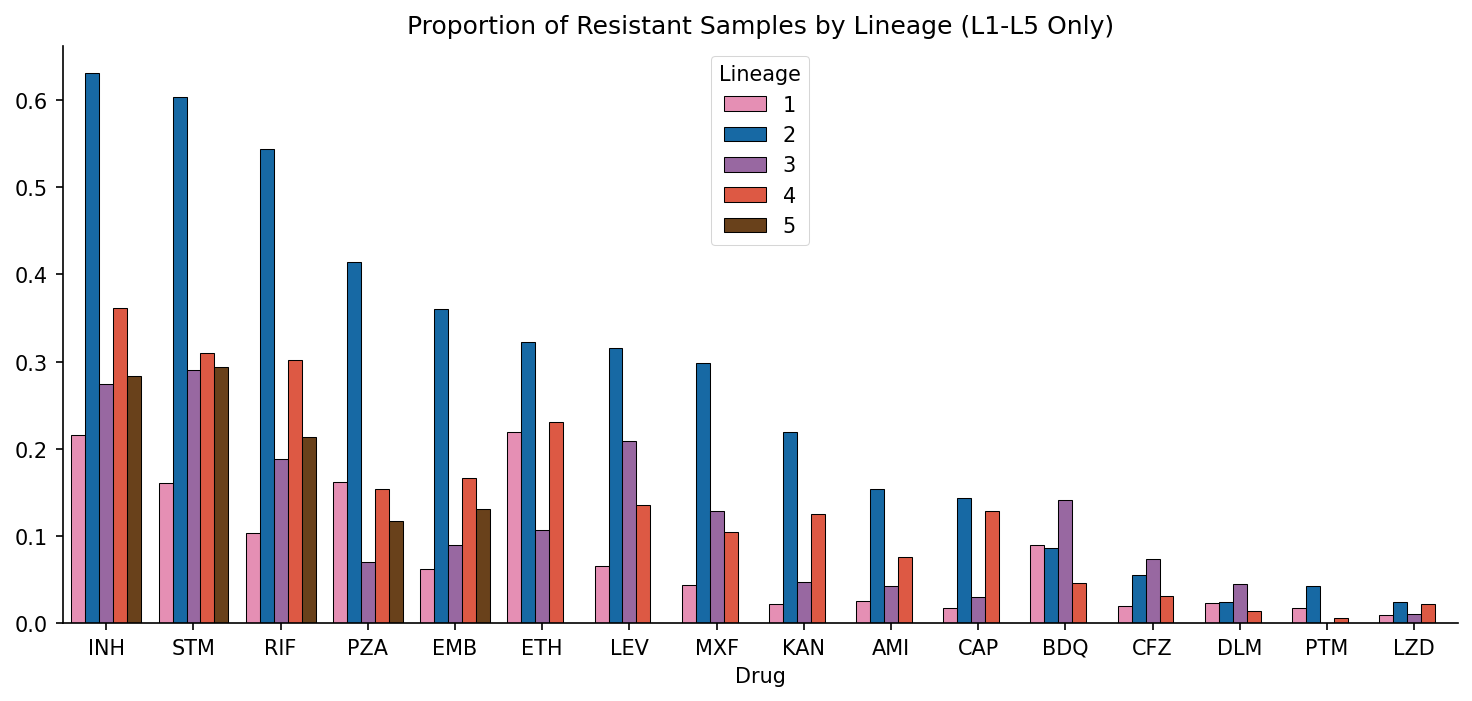

In [203]:
fig, ax = plt.subplots(figsize=(12, 5))

LinToColor_Dict = {"1": "#f381b2",
                   "2": "#006dbb",
                   "3": "#9f5eab",
                   "4": "#f6472b",
                   "5": "#76400e"
                  }

sns.barplot(data=R_by_lineage.sort_values(["max_R_single_drug", "Lineage"], ascending=[False, True]),
            x="Drug",
            y="phenotype",
            hue="Lineage",
            edgecolor="black",
            palette=LinToColor_Dict,
            ax=ax
           )

plt.setp(ax.patches, linewidth=0.5)
plt.legend(title="Lineage", loc="upper center")
plt.ylabel("")
plt.title("Proportion of Resistant Samples by Lineage (L1-L5 Only)")
sns.despine()
plt.savefig("drug_resistance_by_lineage.png", dpi=300)

# 3. Heatmap of Numbers of Mutations in Each Category for Each Drug

In [5]:
def get_single_drug_data_for_heatmap(drug, tiers_lst, folder, solo_results=solo_results):
        
    results = pd.read_excel(f"../results/{folder}/{drug}.xlsx", sheet_name=None)
    
    # keep only unpooled models
    models_lst = list(results.keys())
    models_lst = [path for path in models_lst if "unpooled" in path]

    if len(tiers_lst) == 1:
        models_lst = [path for path in models_lst if "1+2" not in path]
    
    # get only the results dataframes specified above
    results = {key: results[key] for key in models_lst}
    
    # combine results across different models, keeping the first appearance of a mutation
    df = [results[model_name].loc[~pd.isnull(results[model_name]["Odds_Ratio"])] for model_name in list(results.keys())]
    df = pd.concat(df)
    
#     # create dictionary mapping groups to numbers to rank them. Because each mutation may have different gradings in the WHO vs. ALL datasets, keep the highest grading
#     conf_rank_dict = dict(zip(['Uncertain', 'Assoc w R - strict', 'Possible Assoc w R', 'Assoc w S - strict', 'Neutral', 'Possible Assoc w S'],
#                                np.arange(6) + 1
#                              ))
    
#     df["regression_conf_rank"] = df["regression_confidence"].map(conf_rank_dict)
#     df = df.sort_values("regression_conf_rank", ascending=True).drop_duplicates("mutation", keep="first")

    # prioritize the designation in the ALL dataset because it's a more complete (less biased subsample) dataset
    df = df.sort_values("Phenos", ascending=True).drop_duplicates("mutation", keep="first")
    # del df["regression_conf_rank"]
    
    # combine with solo results
    df = solo_results.query("drug==@drug").merge(df[["mutation", "regression_confidence"]], 
                                                 left_on="variant", right_on="mutation", how="inner"
                                                )
    
    df = pd.DataFrame(df["regression_confidence"].value_counts()).reset_index()
    df["Drug"] = drug_abbr_dict[drug]
    return df

In [6]:
def plot_overall_counts_heatmap(tiers_lst, folder="BINARY", drug_order=None, include_uncertain=False, saveName=None):

    if drug_order is None:
        drug_order = os.listdir(analysis_dir)
        
    df_heatmap = []

    for drug in os.listdir(analysis_dir):
        if os.path.isfile(f"../results/{folder}/{drug}.xlsx"):
            df_heatmap.append(get_single_drug_data_for_heatmap(drug, tiers_lst, folder))
        else:
            if drug in drug_order:
                drug_order.remove(drug)

    df_heatmap = pd.concat(df_heatmap, axis=0)
    df_heatmap = df_heatmap.pivot(index="regression_confidence", columns="Drug", values="count").fillna(0)
    
    if include_uncertain:
        group_order = ["Assoc w R - strict", "Possible Assoc w R", "Neutral", "Possible Assoc w S", "Assoc w S - strict", "Uncertain"]
    else:
        group_order = ["Assoc w R - strict", "Possible Assoc w R", "Neutral", "Possible Assoc w S", "Assoc w S - strict"]

    return df_heatmap.loc[group_order, drug_order]

#     plot_width = 0.8*len(group_order)
#     fig, ax = plt.subplots(figsize=(plot_width, 9))
    
#     sns.heatmap(
#                 data=df_heatmap.loc[group_order, drug_order].T,
#                 cmap=sns.light_palette("teal", as_cmap=True),
#                 vmin=0,
#                 # vmax=1,
#                 cbar=False,
#                 square=False,
#                 annot=True,
#                 fmt='g',
#                 linewidths=1, 
#                 linecolor='black',
#                 ax=ax
#                )
    
#     plt.xticks(fontsize=9, rotation=90)
#     plt.yticks(fontsize=9)
#     plt.xlabel("")
#     plt.ylabel("")
#     plt.tight_layout()
    
#     if saveName is None:
#         plt.show()
#     else:
#         if not os.path.isdir(os.path.dirname(saveName)):
#             os.makedirs(os.path.dirname(saveName))
            
#         plt.savefig(saveName, dpi=400)

In [9]:
who_variants_all = pd.read_csv("/n/data1/hms/dbmi/farhat/Sanjana/MIC_data/WHO_resistance_variants_all.csv")
v1_catalog_counts = []

drugs_lst = ["Levofloxacin", "Moxifloxacin", "Bedaquiline", "Clofazimine", "Linezolid", "Delamanid", "Pretomanid", "Rifampicin", "Isoniazid"]

for drug in drugs_lst:
    drug_abbr = drug_abbr_dict[drug]

    high_conf_muts = who_variants_all.query("drug==@drug_abbr & confidence == '1) Assoc w R' & ~variant.str.contains('|'.join(['inframe', 'lof']))")
    
    print(drug, len(high_conf_muts))
    v1_catalog_counts.append(len(high_conf_muts))

Levofloxacin 8
Moxifloxacin 9
Bedaquiline 0
Clofazimine 0
Linezolid 1
Delamanid 0
Pretomanid 0
Rifampicin 25
Isoniazid 6


In [10]:
solo_counts = []

for drug in drugs_lst:
    drug_abbr = drug_abbr_dict[drug]
    high_conf_muts = solo_results.query("drug==@drug & Initial_Confidence_Grading == '1) Assoc w R' & ~variant.str.contains('|'.join(['inframe', 'lof']))")
    print(drug, len(high_conf_muts))
    solo_counts.append(len(high_conf_muts))

Levofloxacin 13
Moxifloxacin 11
Bedaquiline 23
Clofazimine 2
Linezolid 2
Delamanid 1
Pretomanid 0
Rifampicin 24
Isoniazid 8


In [13]:
test = plot_overall_counts_heatmap(["1", "2"], folder="BINARY", drug_order=["LEV", "MXF", "BDQ", "CFZ", "LZD", "DLM", "PTM"])

test.rename(index={"Assoc w R - strict": "Assoc w R", "Possible Assoc w R": "Possible\nAssoc w R", 
                   "Assoc w S - strict": "Assoc w S", "Possible Assoc w S": "Possible\nAssoc w S"
                  }, inplace=True)

test = pd.concat([pd.DataFrame(np.array(v1_catalog_counts).reshape(-1, 1).T, columns=test.columns, index=["SOLO"]),
           test,
          ])
test

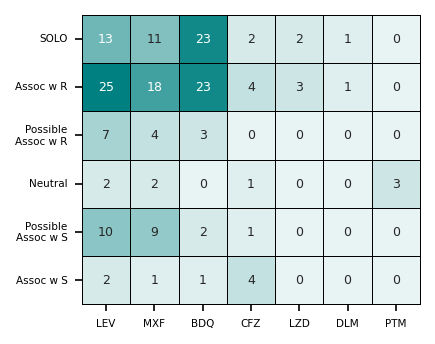

In [36]:
plot_width = 3
fig, ax = plt.subplots(figsize=(3, 3))

sns.heatmap(
            data=test,
            cmap=sns.light_palette("teal", as_cmap=True),
            vmin=0,
            # vmax=1,
            cbar=False,
            square=True,
            annot=True,
            annot_kws={"size": 6},
            fmt='g',
            linewidths=0.25, 
            linecolor='black',
            ax=ax,
            clip_on=False
           )

plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.savefig("../results/TBScience/heatmap_counts_with_SOLO", dpi=300)

In [ ]:
plot_overall_counts_heatmap(["1", "2"], folder="NEW",
                            include_uncertain=True,
                            #saveName="../results/TBScience/heatmap_with_uncertain.png"
                           )

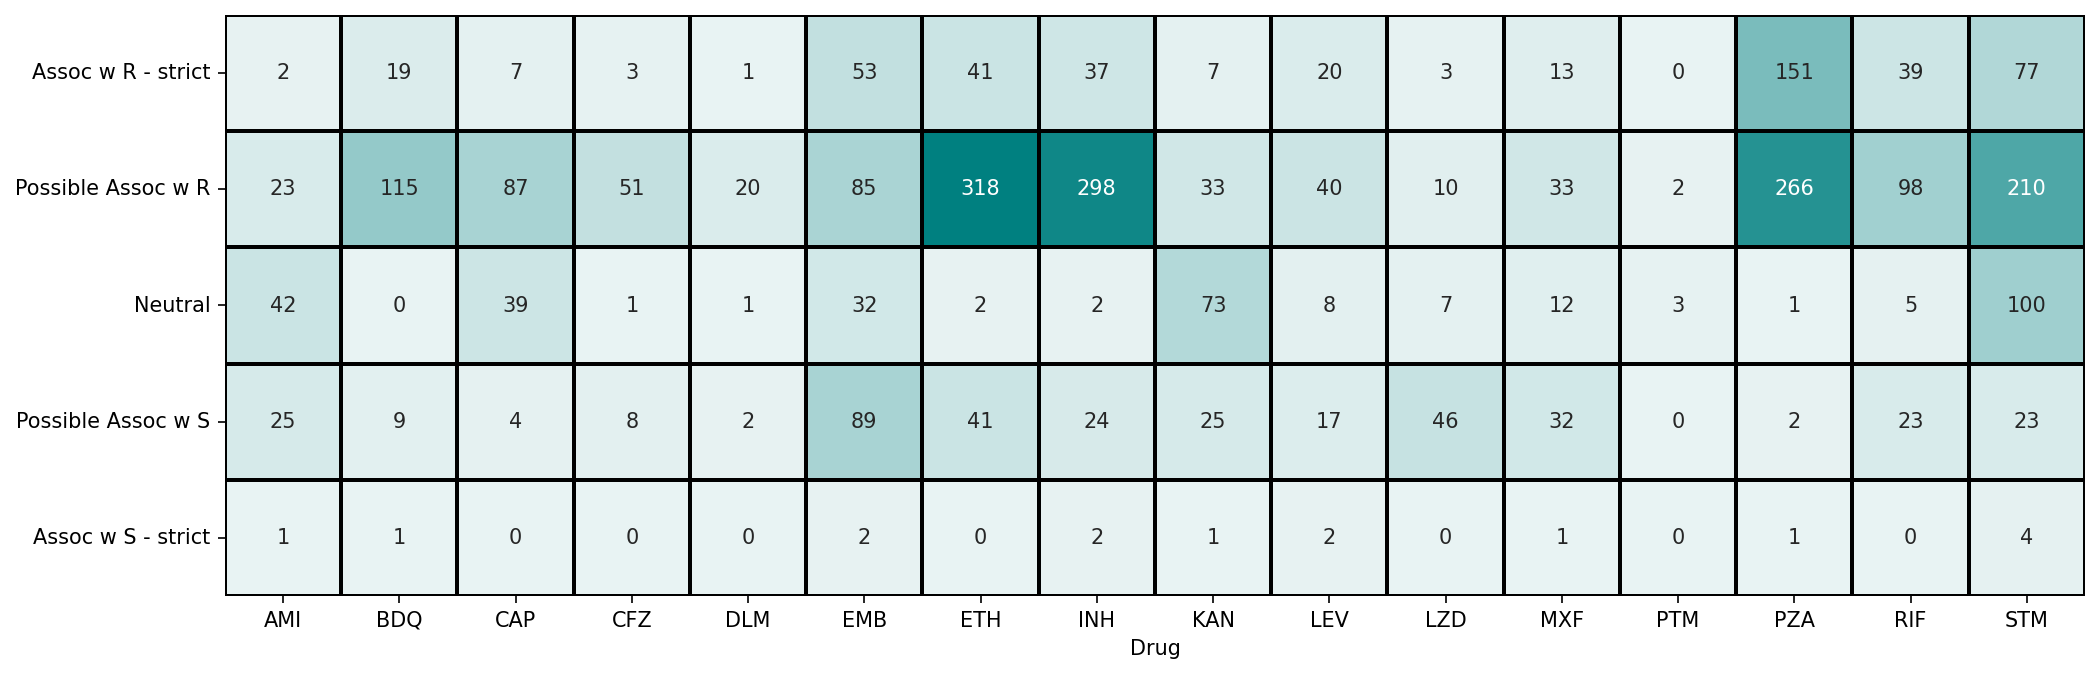

In [69]:
plot_overall_counts_heatmap(["1"], folder="BINARY", saveName="tiers1_heatmap_no_uncertain.png")

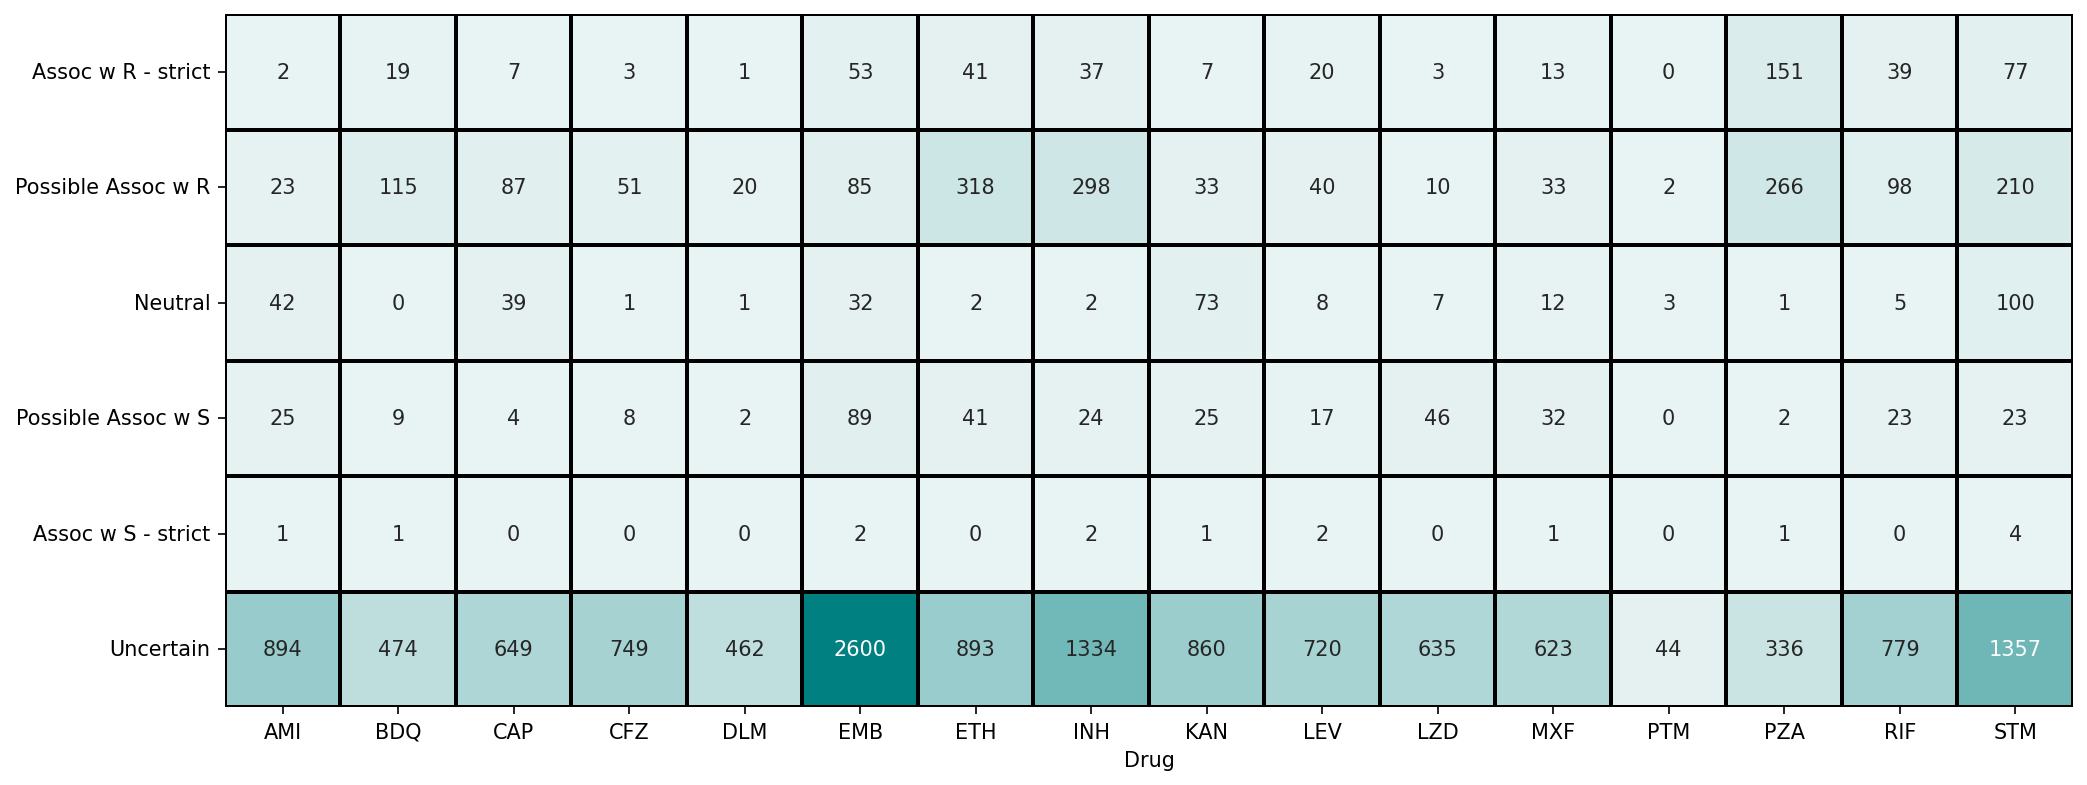

In [70]:
plot_overall_counts_heatmap(solo_results, ["1"], include_uncertain=True, saveName="tiers1_heatmap_uncertain.png")

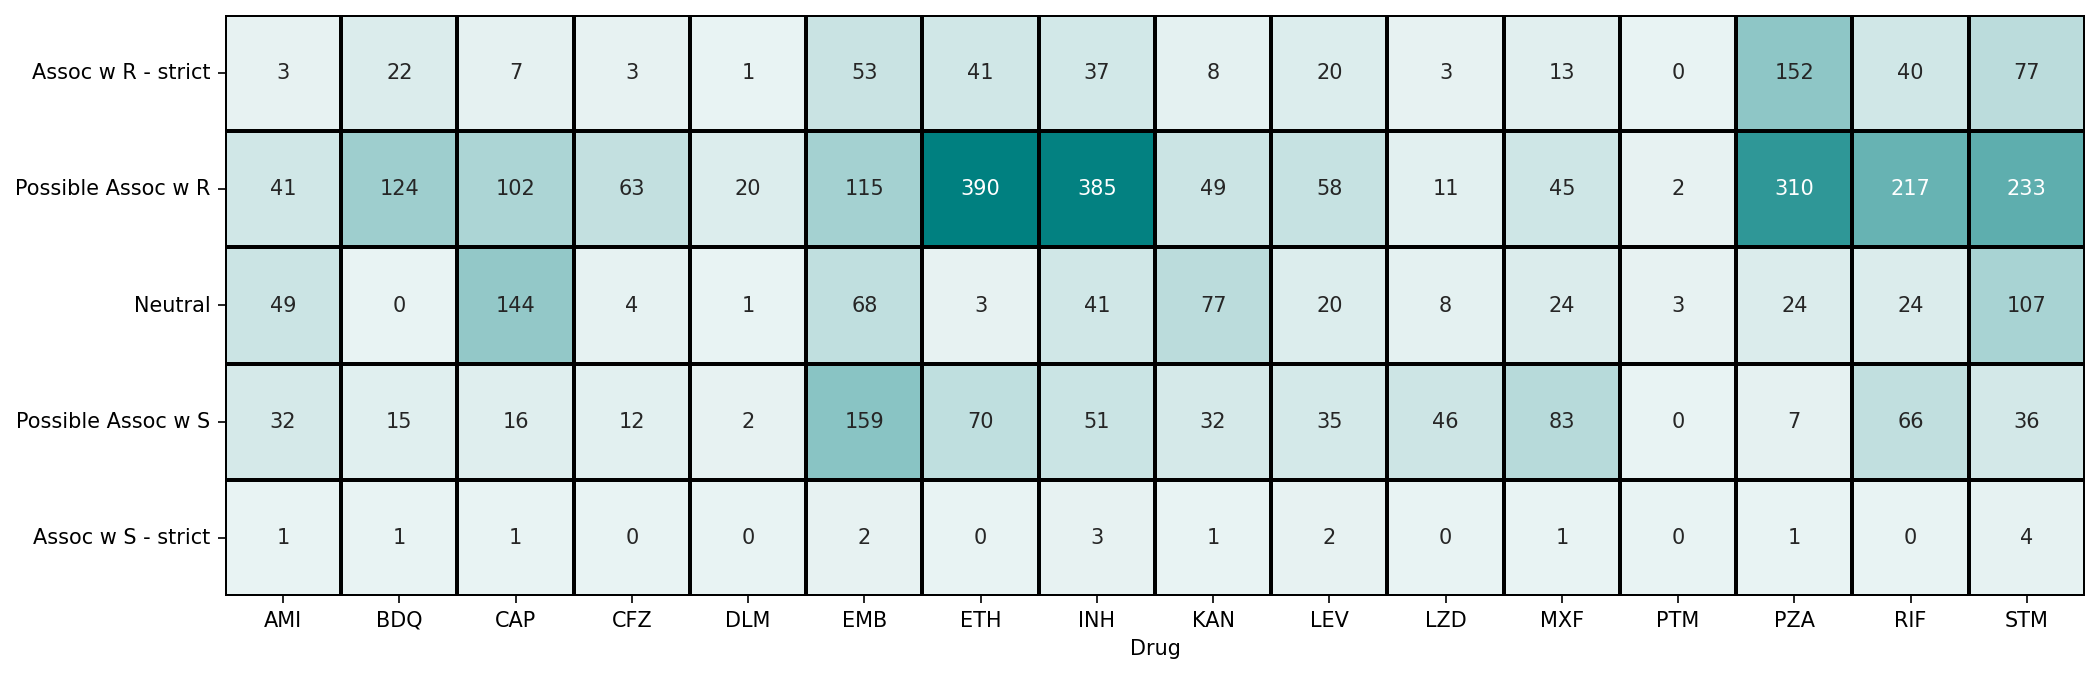

In [68]:
plot_overall_counts_heatmap(solo_results, ["1", "2"], saveName="tiers1+2_heatmap_no_uncertain.png")

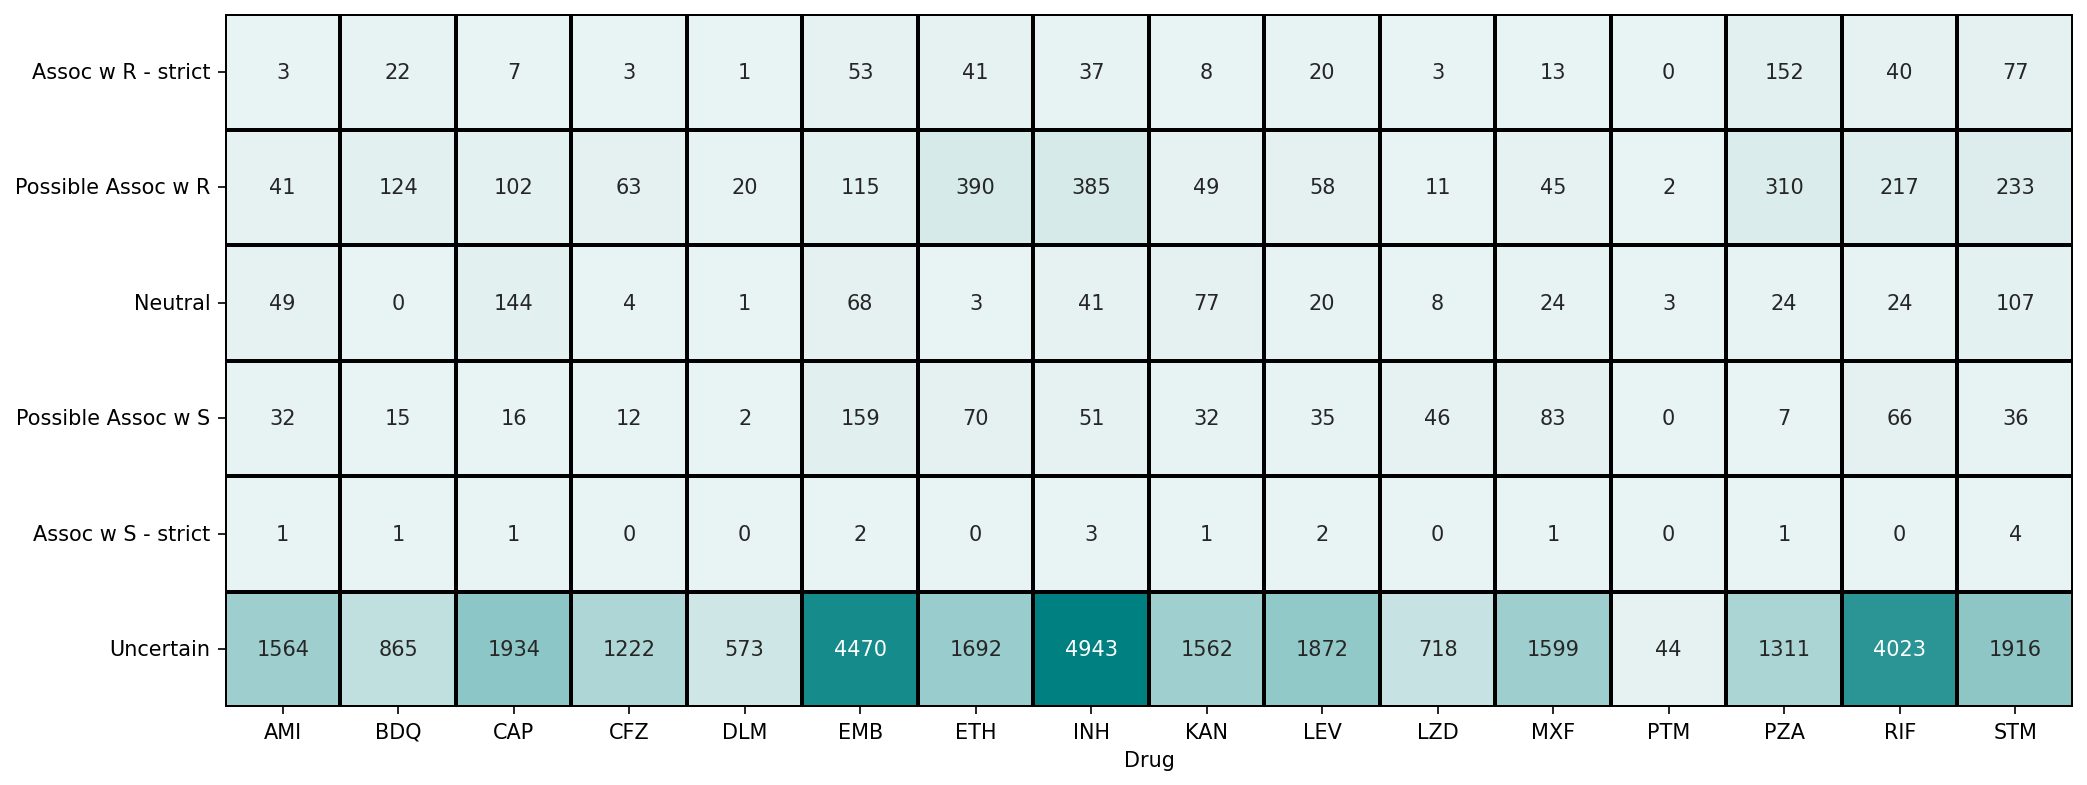

In [71]:
plot_overall_counts_heatmap(solo_results, ["1", "2"], include_uncertain=True, saveName="tiers1+2_heatmap_uncertain.png")

# Sum the Numbers of Variants in Each Category Across all Drugs

In [40]:
tier1_comparison_tables = {}

confidence_mapping = {'1) Assoc w R': "Assoc w R - strict",
                           "2) Assoc w R - Interim": "Possible Assoc w R",
                           "3) Uncertain significance": "Uncertain",
                           "4) Not assoc w R - Interim": "Possible Assoc w S",
                           '5) Not assoc w R': "Assoc w S - strict"
                          }

# for drug in os.listdir(analysis_dir):
for drug in ["Pretomanid", "Linezolid"]:
    
    _, counts_df = make_solo_regression_comparison_table(drug, solo_results, ["1"])
    tier1_comparison_tables[drug] = counts_df
    
summed_tier1_variants_across_drugs = reduce(lambda x, y: x.add(y, fill_value=0), list(tier1_comparison_tables.values()))
summed_tier1_variants_across_drugs

Initial_Confidence_Grading,1) Assoc w R,2) Assoc w R - Interim,3) Uncertain significance,4) Not assoc w R - Interim,5) Not assoc w R
Regression_Confidence_Grading,,,,,
1) Assoc w R,2,0,1,0,0
2) Assoc w R - Interim,0,0,12,0,0
3) Uncertain significance,0,0,679,0,2
4) Not assoc w R - Interim,0,0,46,0,0
5) Not assoc w R,0,0,8,0,0


In [29]:
tier1_comparison_tables["Linezolid"]

Initial_Confidence_Grading,1) Assoc w R,2) Assoc w R - Interim,3) Uncertain significance,4) Not assoc w R - Interim,5) Not assoc w R
Regression_Confidence_Grading,,,,,
1) Assoc w R,2,0,1,0,0
2) Assoc w R - Interim,0,0,10,0,0
3) Uncertain significance,0,0,634,0,2
4) Not assoc w R - Interim,0,0,46,0,0
5) Not assoc w R,0,0,6,0,0


In [30]:
tier1_comparison_tables["Pretomanid"]

Initial_Confidence_Grading,1) Assoc w R,2) Assoc w R - Interim,3) Uncertain significance,4) Not assoc w R - Interim,5) Not assoc w R
Regression_Confidence_Grading,,,,,
1) Assoc w R,0,0,0,0,0
2) Assoc w R - Interim,0,0,2,0,0
3) Uncertain significance,0,0,45,0,0
4) Not assoc w R - Interim,0,0,0,0,0
5) Not assoc w R,0,0,2,0,0


In [38]:
for i, df in enumerate(summed_tier1_variants_across_drugs):
    if sum(df.loc['1) Assoc w R', ['4) Not assoc w R - Interim', '5) Not assoc w R']]) > 0:
        print(i, os.listdir(analysis_dir)[i])

4 Ethambutol
9 Bedaquiline
10 Capreomycin


In [15]:
summed_tiers12_variants_across_drugs = []

for drug in os.listdir(analysis_dir):
    
    _, counts_df = make_solo_regression_comparison_table(drug, solo_results, ["1", "2"])
    summed_tiers12_variants_across_drugs.append(counts_df)
    
summed_tiers12_variants_across_drugs = reduce(lambda x, y: x.add(y, fill_value=0), summed_tiers12_variants_across_drugs)
summed_tiers12_variants_across_drugs

Initial_Confidence_Grading,1) Assoc w R,2) Assoc w R - Interim,3) Uncertain significance,4) Not assoc w R - Interim,5) Not assoc w R
Regression_Confidence_Grading,,,,,
1) Assoc w R,282,7,187,2,2
2) Assoc w R - Interim,36,120,1990,8,11
3) Uncertain significance,6,2,30066,32,202
4) Not assoc w R - Interim,0,0,596,4,62
5) Not assoc w R,0,0,520,12,82


In [179]:
for i, row in df_rif.iterrows():
    
    if "rpoB_p." in row["variant"]:
        AA_pos = row["variant"].replace("rpoB_p.", "")
        
        if "_" not in AA_pos:
            AA_pos = int(AA_pos[3:-3])
        else:
            try:
                AA_pos = int(AA_pos.split("_")[0][-3:])
            except:
                AA_pos = int(AA_pos.split("_")[0][-2:])
            
        df_rif.loc[i, "rpoB_AA"] = AA_pos

In [180]:
df_rif.query("rpoB_AA >= 426 & rpoB_AA <= 452").sort_values("rpoB_AA")[["mutation", "Initial_Confidence_Grading", "regression_confidence", "Regression_Confidence_Grading"]]

,mutation,Initial_Confidence_Grading,regression_confidence,Regression_Confidence_Grading
458,rpoB_p.Gly426_Thr427del,3) Uncertain significance,Uncertain,3) Uncertain significance
457,rpoB_p.Gly426Ser,3) Uncertain significance,Uncertain,3) Uncertain significance
833,rpoB_p.Thr427_Ser428del,3) Uncertain significance,Uncertain,3) Uncertain significance
832,rpoB_p.Thr427_Gln429delinsLys,3) Uncertain significance,Possible Assoc w R,2) Assoc w R - Interim
825,rpoB_p.Thr427Ala,3) Uncertain significance,Possible Assoc w R,2) Assoc w R - Interim
...,...,...,...,...
127,rpoB_p.Ala451Val,3) Uncertain significance,Uncertain,3) Uncertain significance
126,rpoB_p.Ala451Gly,3) Uncertain significance,Uncertain,3) Uncertain significance
588,rpoB_p.Leu452Met,3) Uncertain significance,Uncertain,3) Uncertain significance
589,rpoB_p.Leu452Pro,1) Assoc w R,Assoc w R - strict,1) Assoc w R


# 5. INH Compensatory and Neutral Controls

In [279]:
compens_lst = ['c.-47_-46insT', 'c.-48G>A', 'c.-51G>A', 'c.-81C>T', 'c.-76T>A', 'c.-57C>T', 'c.-52C>T', 'c.-52C>A', 'c.-88_-87insAT', 'c.-77T>G', 'c.-72C>T', 'c.-54C>T', 'c.-74G>A', ]
compens_lst = ["ahpC_" + val for val in compens_lst]

# 'c.-42T>C' not in dataset, but 'c.-42T>G' is
neutral_lst = ['c.-88G>A', 'c.-46G>A', 'c.-84T>C', 'c.-42T>C', 'c.-42T>G', 'c.-88G>A', 'c.-10G>A', 'c.33G>A']
neutral_lst = ["ahpC_" + val for val in neutral_lst]

print(len(np.unique(compens_lst)), len(np.unique(neutral_lst)))

# INH_genos = pd.read_csv(os.path.join(analysis_dir, "Isoniazid/genos_1.csv.gz"), compression="gzip", usecols=["resolved_symbol", "variant_category"]).drop_duplicates() 
# INH_genos["mutation"] = INH_genos["resolved_symbol"] + "_" + INH_genos["variant_category"]
INH_results = pd.read_excel("../results/BINARY/Isoniazid.xlsx", sheet_name=None)

13 7


In [281]:
# INH_genos.query("resolved_symbol=='ahpC' & mutation.str.contains('|'.join(['-84', '-42']))")

In [27]:
print(INH_genos.query("mutation in @compens_lst").shape)
INH_genos.query("mutation in @compens_lst")

(13, 3)


,resolved_symbol,variant_category,mutation
108979348,ahpC,c.-57C>T,ahpC_c.-57C>T
109709938,ahpC,c.-52C>T,ahpC_c.-52C>T
110732764,ahpC,c.-52C>A,ahpC_c.-52C>A
113801242,ahpC,c.-77T>G,ahpC_c.-77T>G
114677950,ahpC,c.-51G>A,ahpC_c.-51G>A
115700776,ahpC,c.-76T>A,ahpC_c.-76T>A
115822868,ahpC,c.-54C>T,ahpC_c.-54C>T
116531633,ahpC,c.-88_-87insAT,ahpC_c.-88_-87insAT
116610172,ahpC,c.-47_-46insT,ahpC_c.-47_-46insT
118168764,ahpC,c.-74G>A,ahpC_c.-74G>A


In [28]:
print(INH_genos.query("mutation in @neutral_lst").shape)
INH_genos.query("mutation in @neutral_lst")

(3, 3)


,resolved_symbol,variant_category,mutation
109275867,ahpC,c.-88G>A,ahpC_c.-88G>A
119259169,ahpC,c.-84T>C,ahpC_c.-84T>C
121383360,ahpC,c.-10G>A,ahpC_c.-10G>A


In [289]:
solo_results.query("drug=='Isoniazid' & variant in @compens_lst")

,drug,variant,Initial_Confidence_Grading
21566,Isoniazid,ahpC_c.-47_-46insT,3) Uncertain significance
21567,Isoniazid,ahpC_c.-48G>A,3) Uncertain significance
21568,Isoniazid,ahpC_c.-51G>A,3) Uncertain significance
21569,Isoniazid,ahpC_c.-52C>A,3) Uncertain significance
21571,Isoniazid,ahpC_c.-52C>T,3) Uncertain significance
21574,Isoniazid,ahpC_c.-54C>T,3) Uncertain significance
21577,Isoniazid,ahpC_c.-57C>T,3) Uncertain significance
21579,Isoniazid,ahpC_c.-72C>T,3) Uncertain significance
21580,Isoniazid,ahpC_c.-74G>A,3) Uncertain significance
21583,Isoniazid,ahpC_c.-76T>A,3) Uncertain significance


# 6. Model Comparisons

<ul>
    <li>SOLO vs. Regression-identified mutations</li>
    <li>Catalog method vs. Regression model</li>
    <li>+/- HETs</li>
</ul>


In [48]:
metrics_components_dict = {'Sens': ['TP', 'FN'],
                           'Spec': ['TN', 'FP'],
                           'PPV': ['TP', 'FP'],
                           'NPV': ['TN', 'FN']
                          }

def compute_ci_ztest(plot_df, var1, var2, cat1, cat2):

    cat1_numerator = plot_df.loc[cat1, var1]
    cat1_denominator = plot_df.loc[cat1, var1] + plot_df.loc[cat1, var2]

    cat2_numerator = plot_df.loc[cat2, var1]
    cat2_denominator = plot_df.loc[cat2, var1] + plot_df.loc[cat2, var2]

    twoSided_pval = statsmodels.stats.proportion.proportions_ztest([cat1_numerator, cat2_numerator], 
                                                             [cat1_denominator, cat2_denominator]
                                                              , alternative='two-sided')[1]

    if twoSided_pval < 0.05:
        
        greater_pval = statsmodels.stats.proportion.proportions_ztest([cat1_numerator, cat2_numerator], 
                                                                 [cat1_denominator, cat2_denominator]
                                                                  , alternative='larger')[1]

        if greater_pval < 0.05:
            return greater_pval
        else:
            # return less than p-value
            return statsmodels.stats.proportion.proportions_ztest([cat1_numerator, cat2_numerator], 
                                                             [cat1_denominator, cat2_denominator]
                                                              , alternative='smaller')[1]
    else:
        # not significant
        return None

In [52]:
def compare_solo_regression_binary_metrics(drug, metrics=["Sens", "Spec", "PPV", "NPV"], include_reg_model=False, saveName=None):

    # no SOLO results for Pretomanid, so will get an error
    if drug == "Pretomanid":
        print("No SOLO results for Pretomanid")
        return None
    
    if drug == "Pretomanid":
        phenos_name = "WHO"
    else:
        phenos_name = "ALL"

    stats = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/model_stats_AF75.csv"), index_col=[0])
    solo_single_drug_stats = solo_binary_stats.query("drug==@drug")
    del solo_single_drug_stats["drug"]

    # compare regression-identified mutations in catalog with regression prediction model
    if include_reg_model:
        plot_df = pd.concat([solo_single_drug_stats, stats], axis=0).rename(index={'Catalog': 'Regression\nCatalog'})
    else:
        plot_df = pd.concat([solo_single_drug_stats, pd.DataFrame(stats.loc["Catalog"]).T], axis=0).rename(index={'Catalog': 'Regression'})

    # Categories and metric names
    categories = plot_df.index.unique()
    num_metrics = len(metrics)
    colors = sns.color_palette("Set2").as_hex()[:len(categories)]
    
    # Bar width and positions
    bar_width = 0.05
    bar_positions = np.arange(len(categories))
    
    # Create subplots for each metric
    if include_reg_model:
        fig_width = 10
    else:
        fig_width = 7
        
    fig, axs = plt.subplots(1, num_metrics, figsize=(fig_width, 4), sharey=True)
    plt.subplots_adjust(wspace=0.15)
    
    errwidth = 0.04
    errlinewidth = 0.5
    
    for i, metric in enumerate(metrics):

        var1, var2 = metrics_components_dict[metric]
        metric_pval = compute_ci_ztest(plot_df, var1, var2, plot_df.index.values[0], plot_df.index.values[1])
        
        ax = axs[i]
        
        # Plot bars for each category
        for j, category in enumerate(categories):
    
            test = plot_df.loc[category][metric] * 100
            lower = plot_df.loc[category][f"{metric}_lb"] * 100
            upper = plot_df.loc[category][f"{metric}_ub"] * 100
            
            # Plot the test value as a bar
            patch = ax.bar(j, test, color=colors[j])
            ax.bar_label(patch, label_type='center', fmt='%.1f')
            
            # Plot the confidence interval as a vertical line
            ax.vlines(j, lower, upper, color='black', linewidth=errlinewidth)
    
            # plot horizontal lines to make the error bars look nicer
            ax.hlines(lower, j - errwidth, j + errwidth, color='black', linewidth=errlinewidth)
            ax.hlines(upper, j - errwidth, j + errwidth, color='black', linewidth=errlinewidth)
        
        # Set axis labels and title
        if metric_pval is not None:

            if metric_pval < 0.01:
                metric_pval = "{:.0e}".format(metric_pval)
            else:
                metric_pval = np.round(metric_pval, 2)
            
            ax.set_title(f"{metric}:\npval = {metric_pval}")
        else:
            ax.set_title(f"{metric}:\npval = ns")
        
        # Set x-axis ticks and labels
        ax.set_xticks(bar_positions)
        ax.set_xticklabels(categories)
    
    # Show the plot
    sns.despine()
    plt.suptitle(drug)
    plt.tight_layout()
    plt.ylim(0, 100)

    if saveName is None:
        plt.show()
    else:
        plt.savefig(saveName, dpi=300)

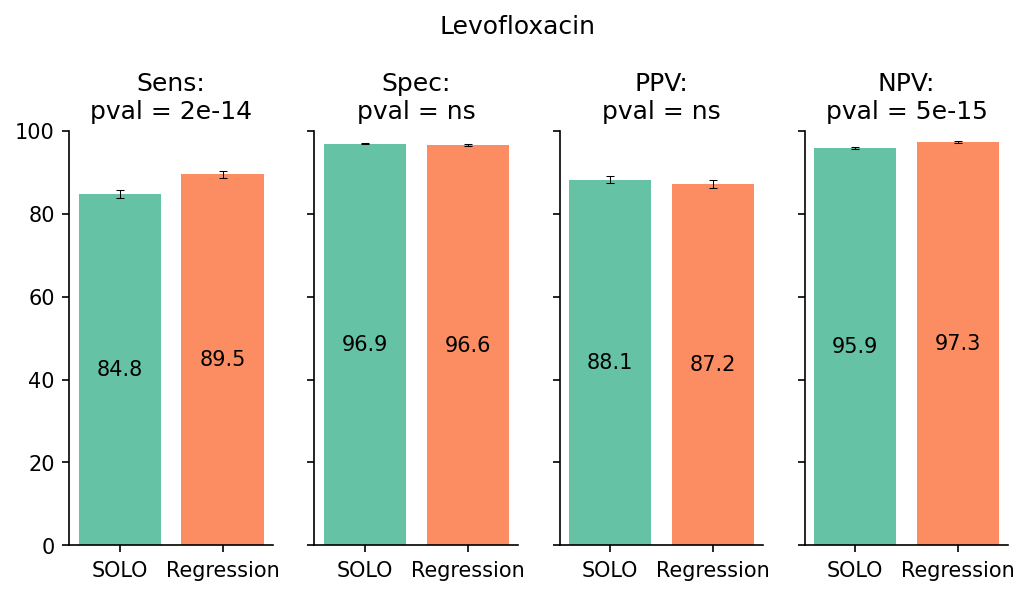

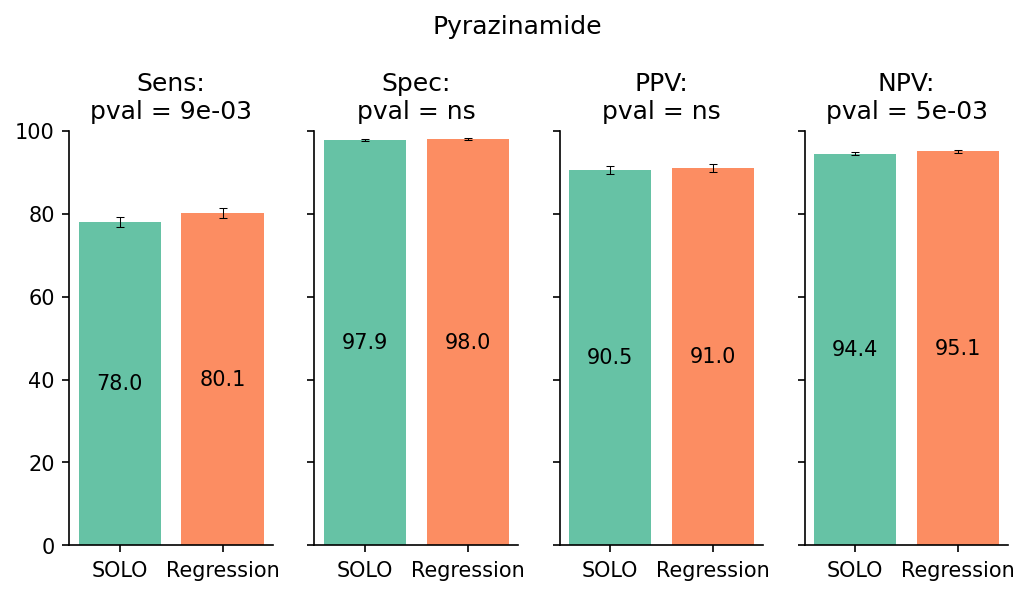

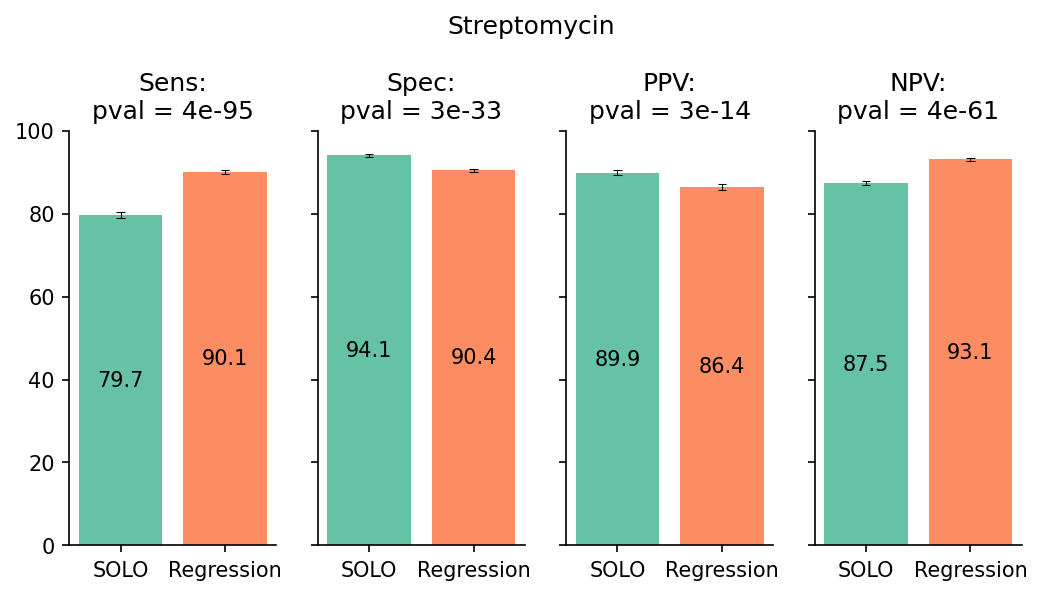

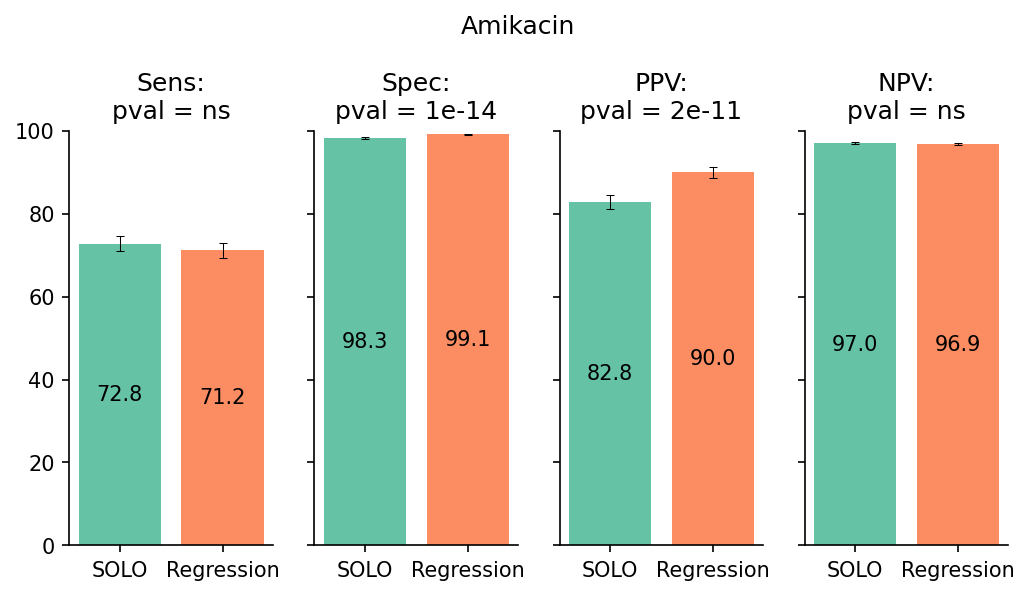

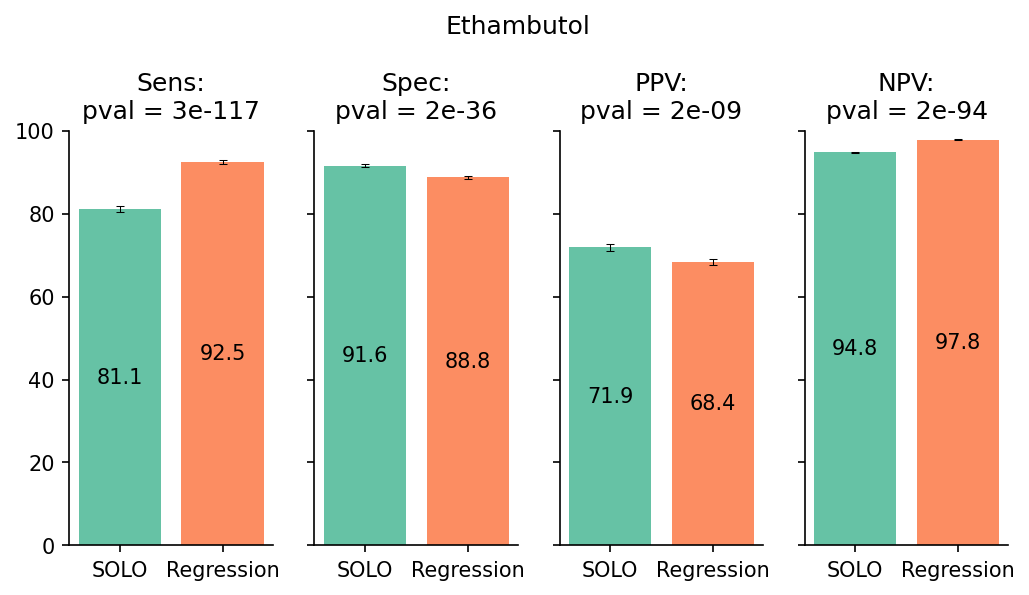

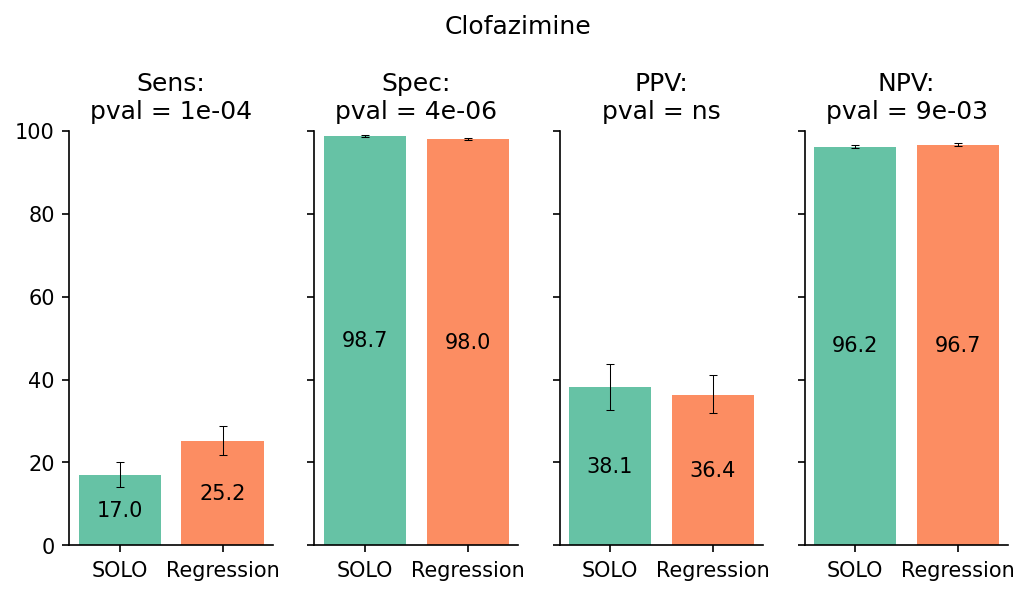

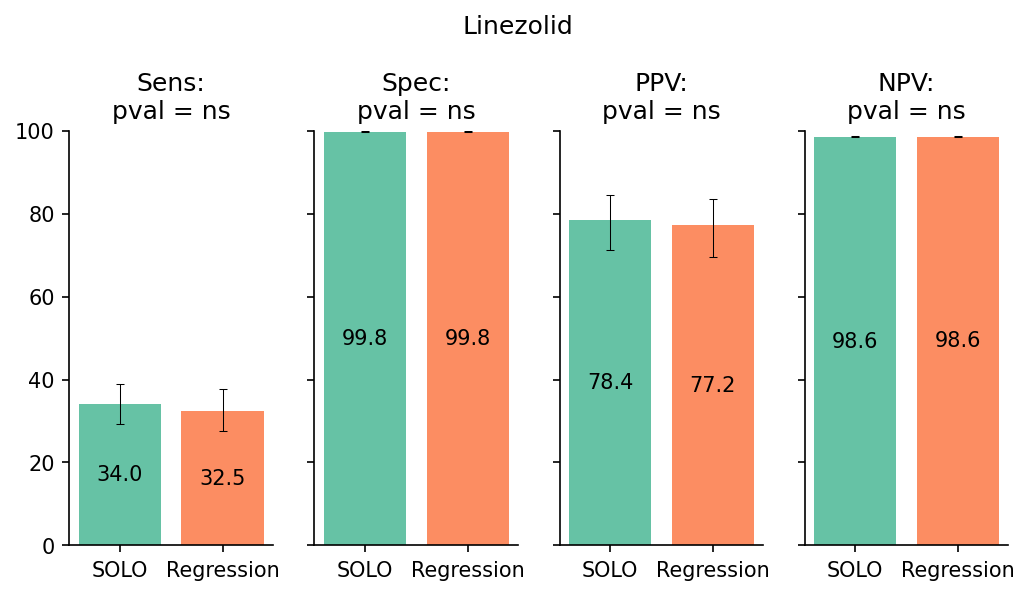

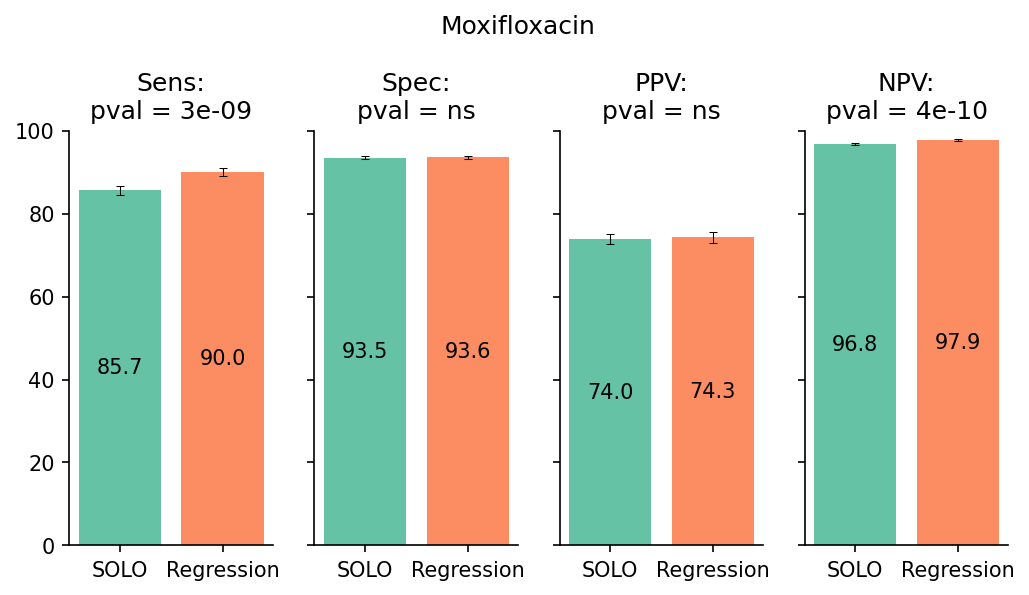

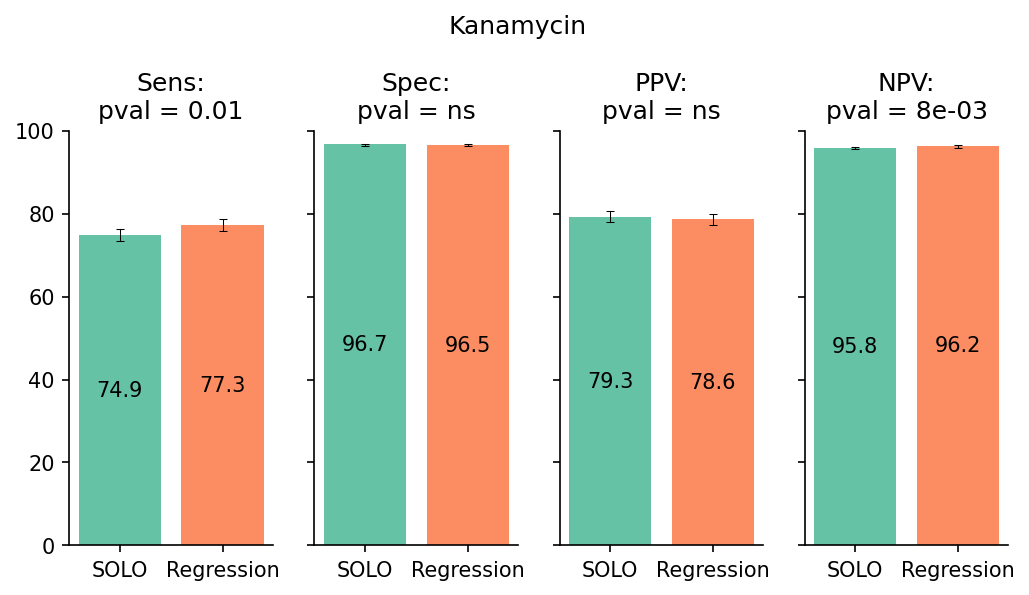

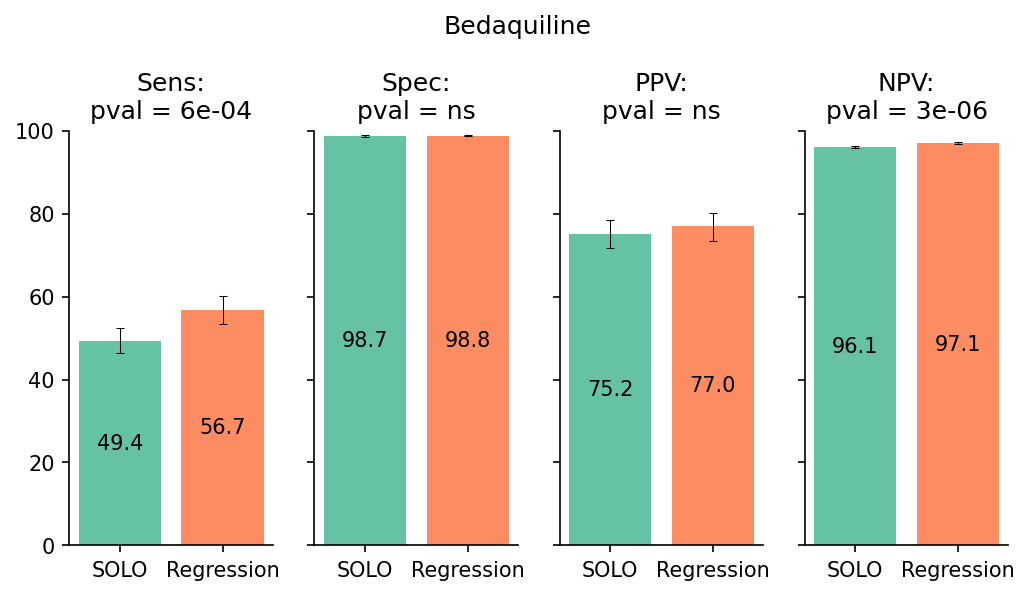

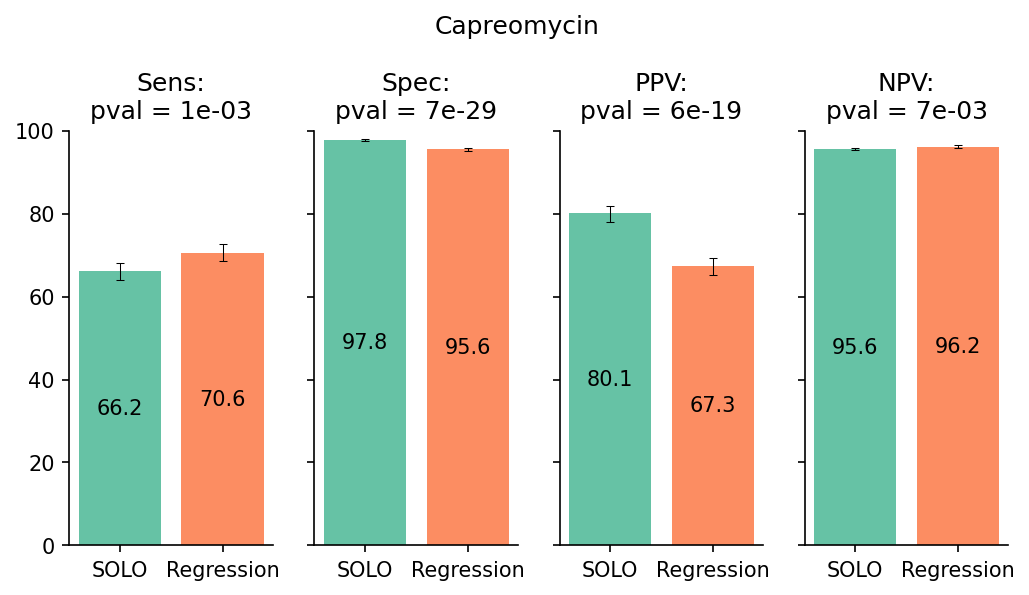

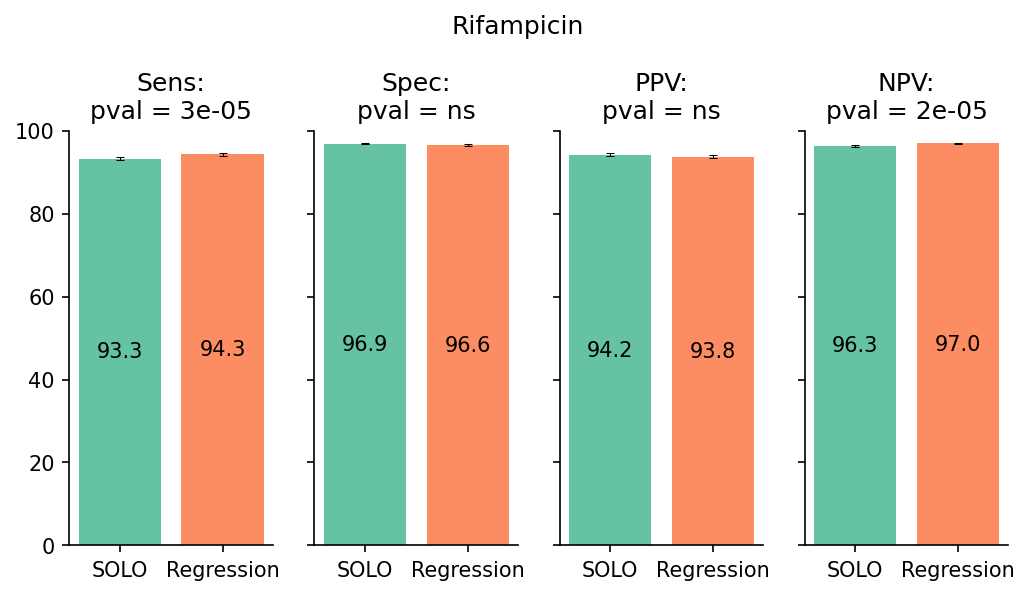

No SOLO results for Pretomanid


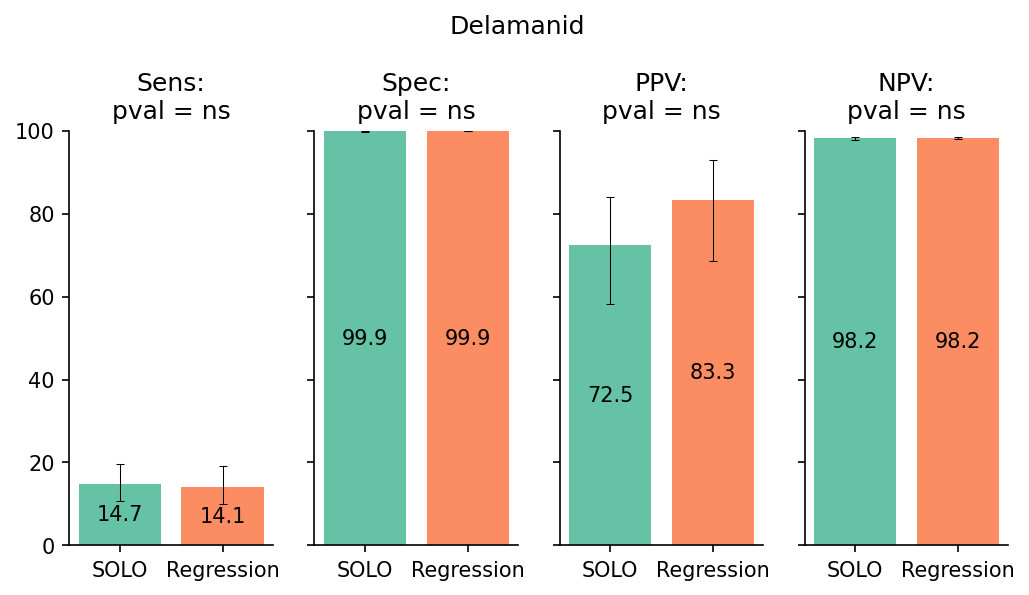

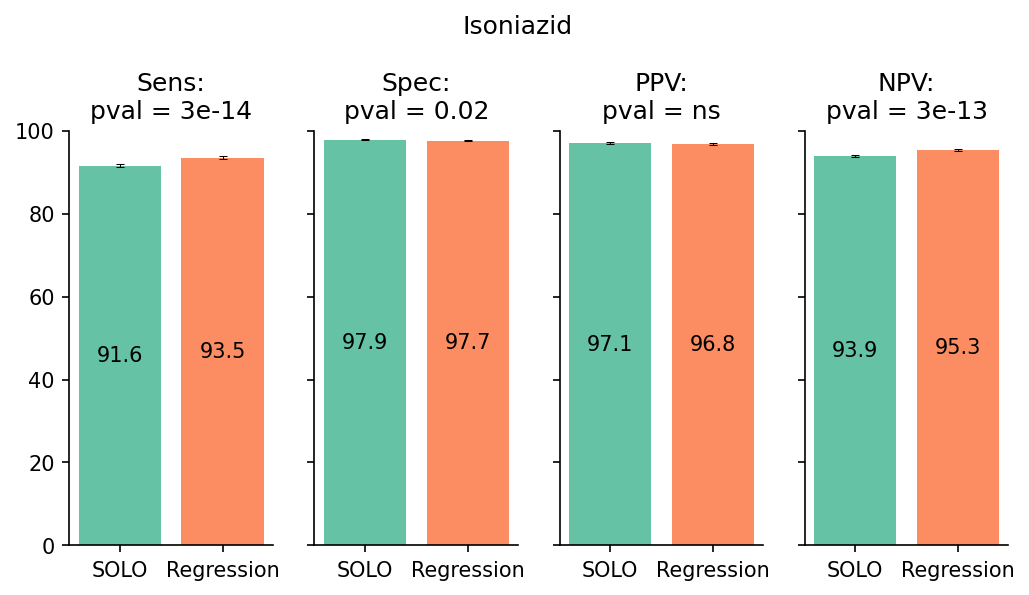

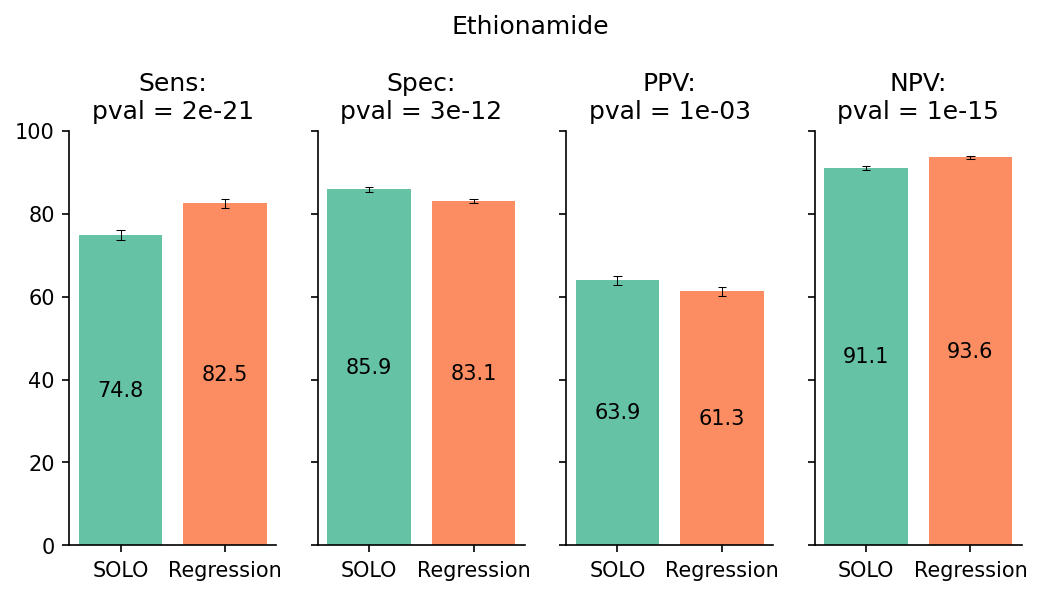

In [53]:
for drug in np.sort(drugs_lst):
    compare_solo_regression_binary_metrics(drug)

In [226]:
def compare_hets_regression(drug, metrics=["Sens", "Spec", "PPV", "NPV"], model_type="Catalog", saveName=None):

    if drug == "Pretomanid":
        phenos_name = "WHO"
    else:
        phenos_name = "ALL"

    stats = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/model_stats_AF75.csv"), index_col=[0])
    stats_het = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/model_stats_AF25.csv"), index_col=[0])
        
    # compare regression-identified mutations in catalog with regression prediction model
    plot_df = pd.concat([pd.DataFrame(stats.loc[model_type]).T.rename(index={model_type: '-HETs'}), 
                         pd.DataFrame(stats_het.loc[model_type]).T.rename(index={model_type: '+HETs'})
                        ], axis=0)

    # Categories and metric names
    categories = plot_df.index.unique()
    num_metrics = len(metrics)
    colors = sns.color_palette("Set2").as_hex()[:len(categories)]
    
    # Bar width and positions
    bar_width = 0.05
    bar_positions = np.arange(len(categories))
    
    # Create subplots for each metric
    fig_width = 7
        
    fig, axs = plt.subplots(1, num_metrics, figsize=(fig_width, 4), sharey=True)
    plt.subplots_adjust(wspace=0.15)
    
    errwidth = 0.04
    
    for i, metric in enumerate(metrics):
        ax = axs[i]
        
        # Plot bars for each category
        for j, category in enumerate(categories):
    
            test = plot_df.loc[category][metric] * 100
            lower = plot_df.loc[category][f"{metric}_lb"] * 100
            upper = plot_df.loc[category][f"{metric}_ub"] * 100
            
            # Plot the test value as a red dot
            patch = ax.bar(j, test, color=colors[j])
            ax.bar_label(patch, label_type='center', fmt='%.1f')
            # ax.bar_label(j, test, color=colors[j])
            
            # Plot the confidence interval as a vertical line
            ax.vlines(j, lower, upper, color='black', linewidth=1)
    
            # plot horizontal lines to make the error bars look nicer
            ax.hlines(lower, j - errwidth, j + errwidth, color='black', linewidth=1)
            ax.hlines(upper, j - errwidth, j + errwidth, color='black', linewidth=1)
        
        # Set axis labels and title
        ax.set_title(metric)
        
        # Set x-axis ticks and labels
        ax.set_xticks(bar_positions)
        ax.set_xticklabels(categories)
    
    # Show the plot
    sns.despine()
    plt.suptitle(drug)
    plt.tight_layout()
    plt.ylim(0, 100)

    if saveName is None:
        plt.show()
    else:
        plt.savefig(saveName, dpi=300)

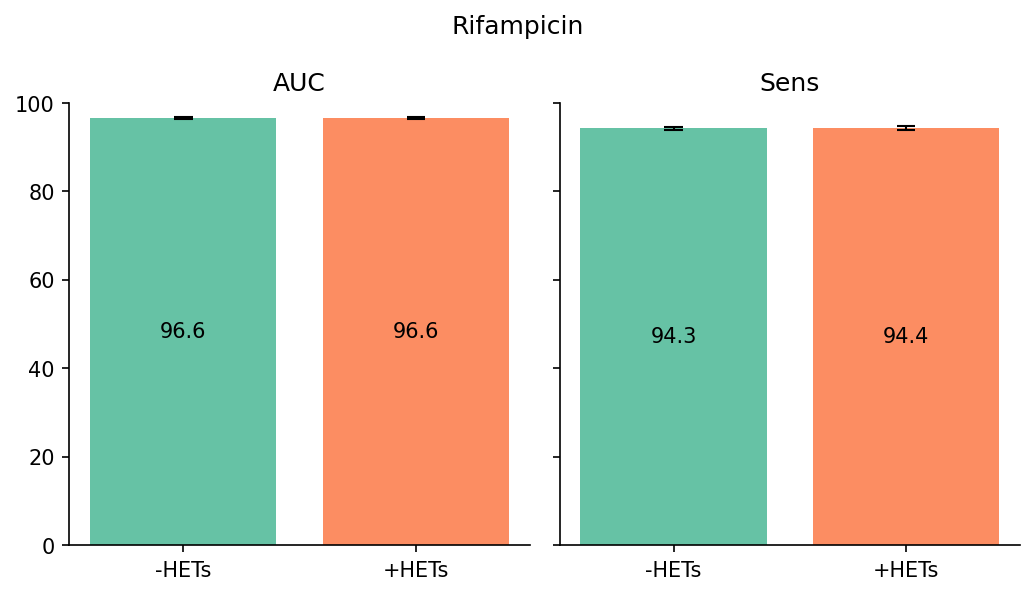

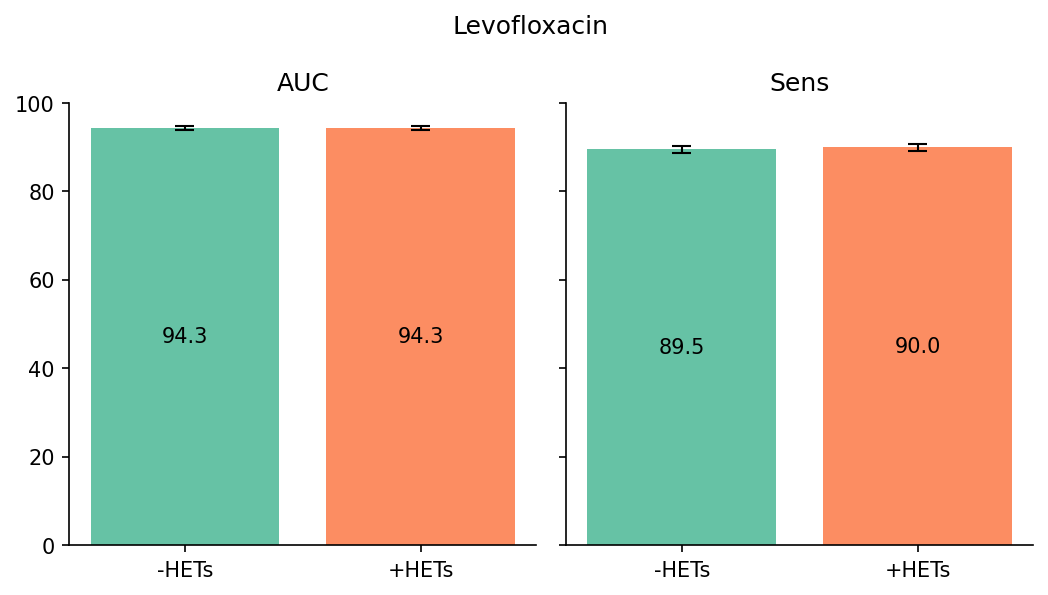

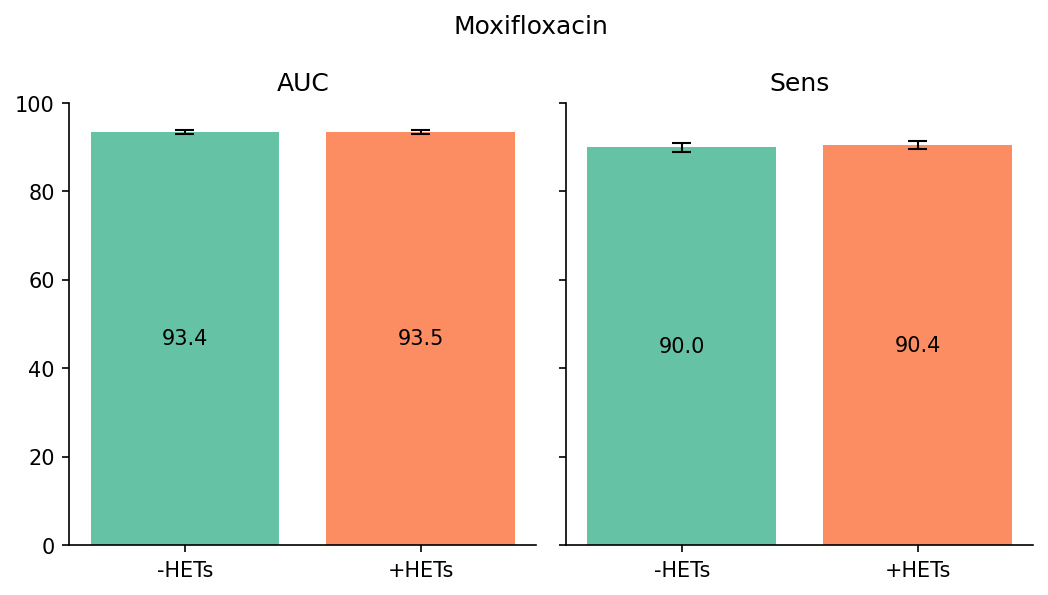

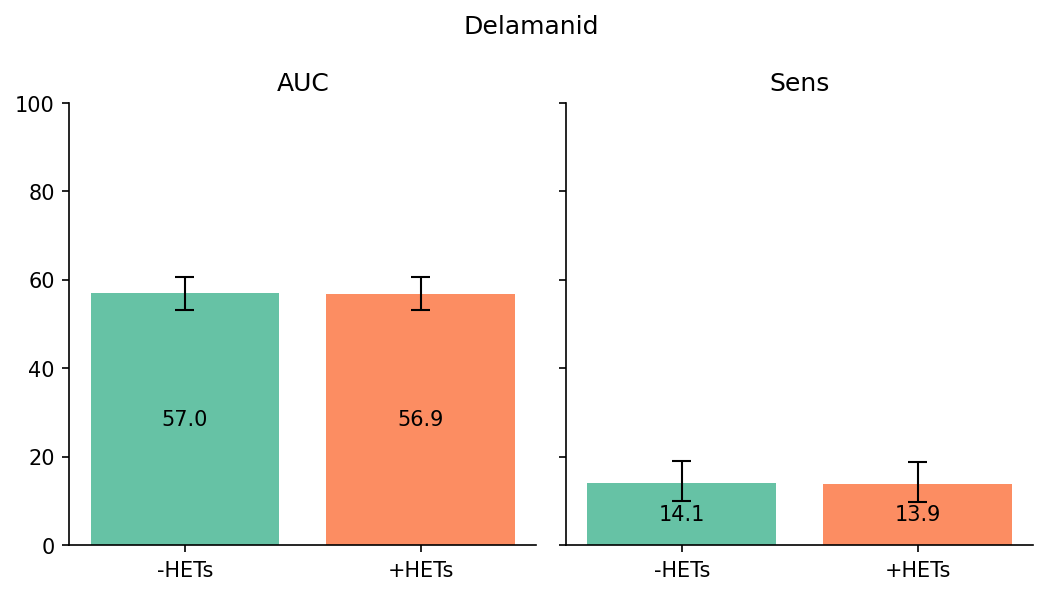

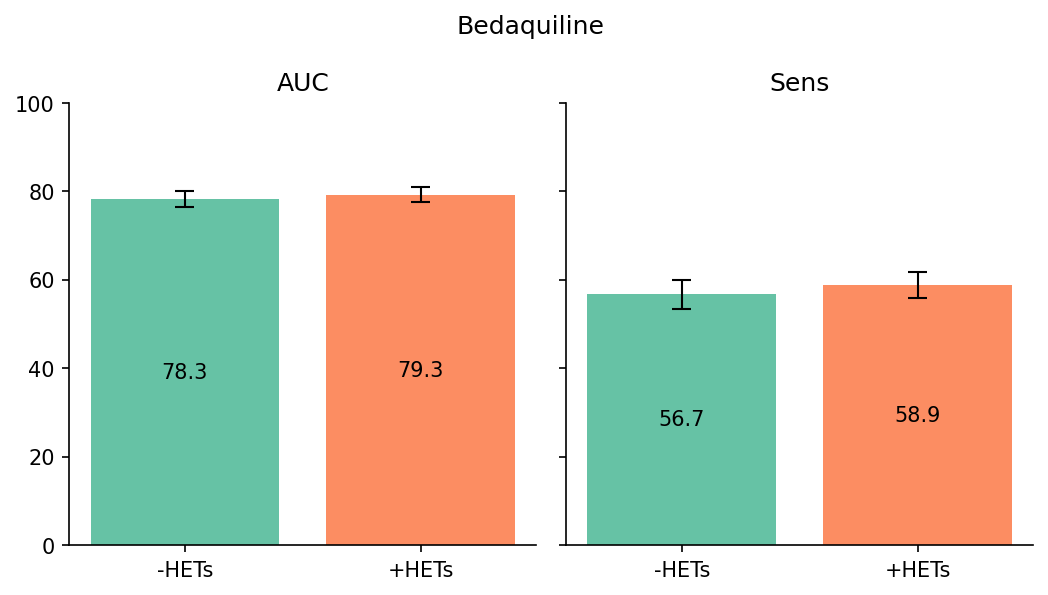

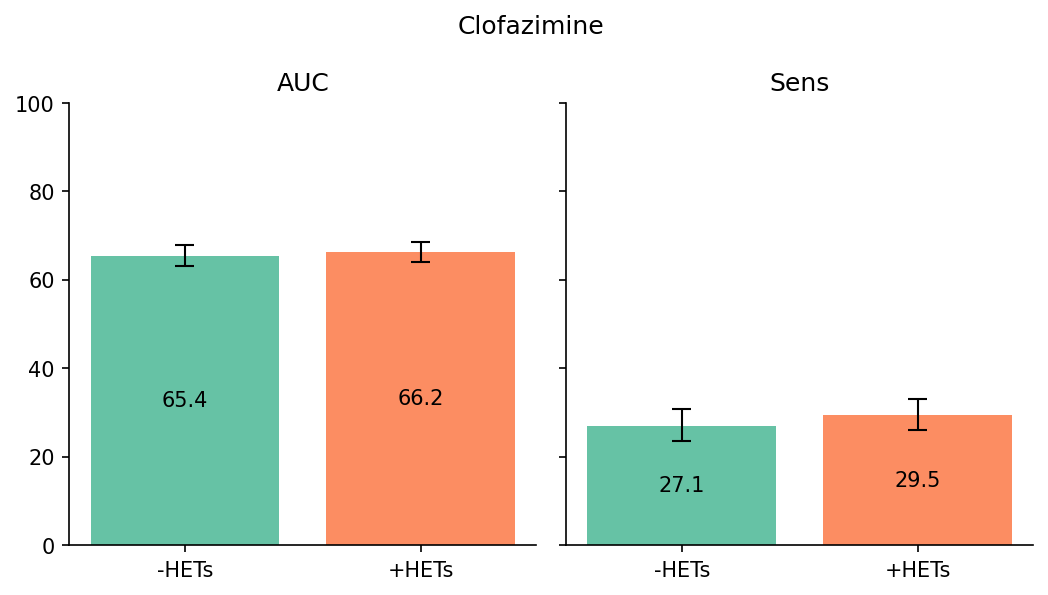

In [227]:
for drug in ["Rifampicin", "Levofloxacin", "Moxifloxacin", "Delamanid", "Bedaquiline", "Clofazimine"]:
    compare_hets_regression(drug, metrics=["AUC", "Sens"], model_type="Regression")